
# Rossmann Sales Forecasting — Multiple Model Comparison  

### Problem Statement
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has requested to forecast Sales data.

### Objectives

To build **several forecasting models** for Rossmann stores and compares them:

1. **Naive Last-Value Forecast**
2. **ARIMA**
3. **SARIMA**
4. **SARIMAX** (with exogenous regressors like Promo / holidays)
5. **VAR / VECM** (multivariate time series with Sales, Customers, promos)

We work on the **nine key stores**:
`1, 3, 8, 9, 13, 25, 29, 31, 46`

The data comes from:
- `train.csv` — daily sales for each store
- `store.csv` — store-level metadata

### Main Steps

1. Load and merge data, filter to key stores & open days.
2. Remove **outliers** (> 99th percentile per store) in `Sales`.
3. Split into **train** and **test** (last 6 weeks ≈ 42 days as test).
4. Build and evaluate:
   - Last-value forecast
   - ARIMA
   - SARIMA
   - SARIMAX
   - VAR / VECM
5. Compute **MAPE** (Mean Absolute Percentage Error) on the test set.
6. Generate **6-week-ahead forecasts** from the best models.


## 1. Imports & Global Settings

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels: time series and regression
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

from sklearn.preprocessing import StandardScaler

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")
# Plot inline (if running in Jupyter)
%matplotlib inline

# Display settings
pd.set_option("display.max_columns", 100)


## 2. Helper Functions

In [2]:

def print_null_summary(df):

      n_rows = len(df)
      null_counts = df.isnull().sum()
      null_pct = (null_counts / n_rows) * 100

      null_summary = (
          pd.DataFrame({
            "Null Count": null_counts,
            "Null Percentage": null_pct.round(2)
          }).sort_values("Null Percentage", ascending=False)
      )
      return null_summary

def mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE (in %) and ignore points where y_true == 0."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def adf_test(series, title=""):
    """Run Augmented Dickey-Fuller test and print summary."""
    print(f"\nADF Test: {title}")
    series = series.dropna()
    result = adfuller(series, autolag="AIC")
    labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations Used"]
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    for key, val in result[4].items():
        print(f"Critical Value {key}: {val}")
    if result[1] <= 0.05:
        print("=> Likely STATIONARY (reject H0)")
    else:
        print("=> Likely NON-STATIONARY (fail to reject H0)")


def johansen_cointegration_test(df, cols, det_order=0, k_ar_diff=1):
    """Run Johansen cointegration test on specified columns."""
    x = df[cols].dropna().values
    result = coint_johansen(x, det_order, k_ar_diff)

    print("\nJohansen Cointegration Test (Trace Statistics):")
    print("Trace statistics:", result.lr1)
    print("Critical values (90%, 95%, 99%):\n", result.cvt)

    # Estimate cointegration rank where trace statistic > 95% critical value
    rank = 0
    for i in range(len(result.lr1)):
        if result.lr1[i] > result.cvt[i, 1]:  # 95% column
            rank = i + 1
    print(f"Estimated cointegration rank (at 5%): {rank}")
    return rank


## 3. Load, Merge & Filter Data

In [3]:

# File paths (update if needed)
TRAIN_PATH = "train.csv"
STORE_PATH = "store.csv"

# Load data
train = pd.read_csv(TRAIN_PATH)
store = pd.read_csv(STORE_PATH)

# Parse dates
train["Date"] = pd.to_datetime(train["Date"])

# Merge store metadata into train
df = train.merge(store, on="Store", how="left")

# Key stores of interest
KEY_STORES = [1, 3, 8, 9, 13, 25, 29, 31, 46]
df = df[df["Store"].isin(KEY_STORES)].copy()

# Sort by store and date
df.sort_values(["Store", "Date"], inplace=True)

print("Shape after filtering:", df.shape)
df.head()

Shape after filtering: (8110, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## 3. Handle Null Values

In [4]:
# Print Null Summary
print_null_summary(df)

,Null Count,Null Percentage
Promo2SinceWeek,5652,69.69
PromoInterval,5652,69.69
Promo2SinceYear,5652,69.69
CompetitionOpenSinceYear,1700,20.96
CompetitionOpenSinceMonth,1700,20.96
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Customers,0,0.00
Sales,0,0.00


In [5]:
# Mean can be pulled by very large distances; median is robust to outliers.
competition_distance_median = df['CompetitionDistance'].median()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(competition_distance_median)

# Missing competition opening dates likely indicate no known competitor, so filling it with 0
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df["CompetitionOpenSinceYear"]  = df["CompetitionOpenSinceYear"].fillna(0).astype(int)

# PromoInterval is string, so we fill NAs with "None"
df["PromoInterval"] = df["PromoInterval"].fillna("None")

# If a store does not participate in Promo2 (Promo2 = 0), then:
    ## It has no start year (Promo2SinceYear),
    ## no start week (Promo2SinceWeek),
    ## no months where Promo2 runs (PromoInterval).
df["Promo2"] = df["Promo2"].fillna(0).astype(int)
df["Promo2SinceYear"] = df["Promo2SinceYear"].fillna(0).astype(int)
df["Promo2SinceWeek"] = df["Promo2SinceWeek"].fillna(0).astype(int)

In [6]:
print_null_summary(df)

,Null Count,Null Percentage
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0
StoreType,0,0.0


## 4. Data Preparation and Feature Engineering

In [7]:
# Convert Column- Date to DateTime
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

# Filter the rows when Store was Open
# Since, forecasting sales when the store is operating, not when it’s closed.
df['Open'] = df['Open'].apply(lambda x: 0 if np.isnan(x) else x)
df = df[ df['Open'] == 1 ]

# Remove any weird Sales data
df = df[ df['Sales'] >= 0 ]

In [8]:
# Extract New Columns
df['Year']       = df['Date'].apply(lambda x: x.year)
df['Month']      = df['Date'].apply(lambda x: x.month)
df['Day']        = df['Date'].apply(lambda x: x.day)
df['WeekOfYear'] = df['Date'].apply(lambda x: x.weekofyear)
df['DayOfYear']  = df['Date'].apply(lambda x: x.dayofyear)
df['Weekend']    = (df['Date'].dt.isocalendar().day >= 6).astype(int)

## 5. Fix Data Types

In [9]:
# Convert Discrete float fields to int
to_int_cols = ["DayOfWeek", "Open", "SchoolHoliday", "Promo", "Promo2", "Customers",
                "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

for col in to_int_cols:
    df[col] = df[col].astype(int)

# Holiday field is String/Categorical
df["StateHoliday"] = df["StateHoliday"].astype(str)
# StoreType field String/Categorical
df["StoreType"] = df["StoreType"].astype(str)
# PromoInterval field String/Categorical
df["PromoInterval"] = df["PromoInterval"].astype(str)

print(df.dtypes)

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
Year                                  int64
Month                                 int64
Day                                   int64
WeekOfYear                            int64
DayOfYear                       

## 6. Sort Data

In [10]:
# Sort Data based on Date and Sales
df = df.sort_values(by=['Date', 'Sales'], ascending=[True, False])
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,DayOfYear,Weekend
1015004,25,3,2013-01-02,11944,1698,1,0,0,1,c,a,430.0,4,2003,0,0,0,None,2013,1,2,1,2,0
1014982,3,3,2013-01-02,6823,805,1,0,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2013,1,2,1,2,0
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,2,1,2,0
1014987,8,3,2013-01-02,5419,698,1,0,0,1,a,a,7520.0,10,2014,0,0,0,None,2013,1,2,1,2,0
1015008,29,3,2013-01-02,5269,550,1,0,0,1,d,c,2170.0,0,0,0,0,0,None,2013,1,2,1,2,0


## 7. EDA

### 7.1 Classify Columns

In [11]:
cat_cols = {
        "DayOfWeek", "Open", "Promo", "StateHoliday", "SchoolHoliday",
        "StoreType", "Assortment", "CompetitionOpenSinceMonth",
        "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek",
        "Promo2SinceYear", "PromoInterval", "Year", "Month", "Day",
        "WeekOfYear", "Weekend"
    }

num_cols = {
        "Store", "Sales", "Customers", "CompetitionDistance", "DayOfYear"
    }

### 7.2 Univariate Analysis - Numerical Columns

In [12]:
def plot_univariate_numeric(df: pd.DataFrame, num_cols: list, bins: int = 30):

    sns.set(style="whitegrid", font_scale=1.1)

    for col in num_cols:

        data = df[col]

        if np.issubdtype(data.dtype, np.datetime64):
            continue

        fig, axis = plt.subplots(1, 2, figsize=(15, 5))

        # Histogram + KDE
        ax = axis[0]
        sns.histplot(data, kde=True, bins=bins, color="blue", ax=ax)

        ax.set_title(f"Distribution of {col}", fontsize=13, weight="bold")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend()

        # --- Boxplot ---
        bx = axis[1]
        sns.boxplot(x=data, color="orange", ax=bx)
        bx.set_title(f"Boxplot of {col}", fontsize=13, weight="bold")
        bx.set_xlabel(col)

        # Highlight outliers numerically
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers_count = ((data < lower) | (data > upper)).sum()

        bx.text(
            0.98, 0.95,
            f"Outliers: {outliers_count}",
            transform=bx.transAxes,
            ha="right", va="top",
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
        )

        plt.suptitle(f"Univariate Analysis : {col}", fontsize=14, weight="bold")
        plt.tight_layout()
        plt.show()


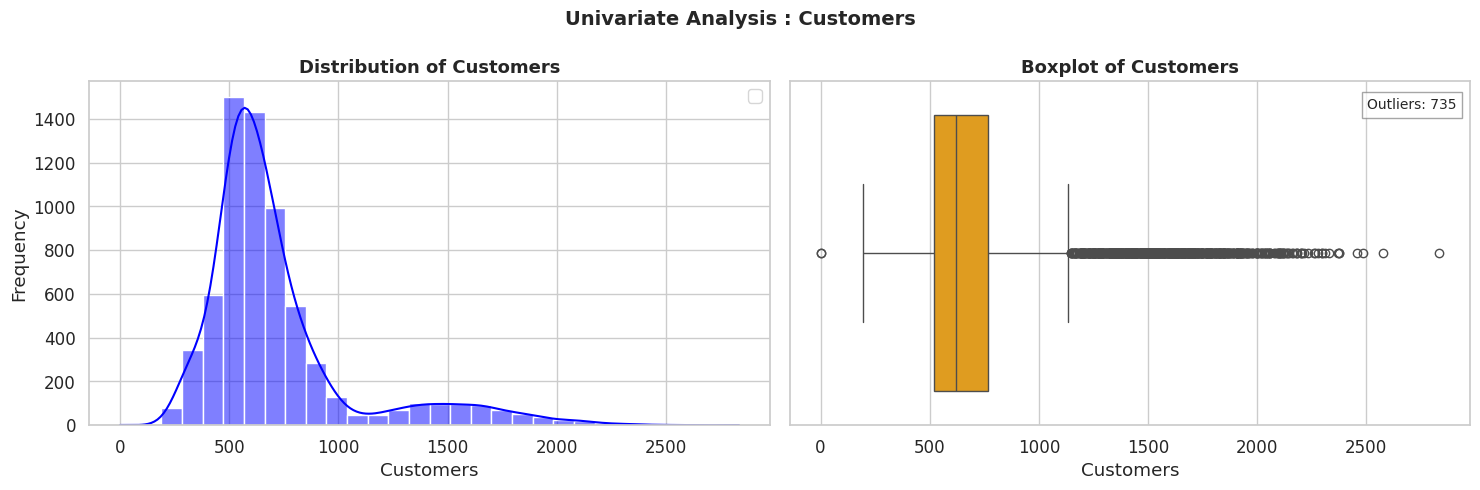

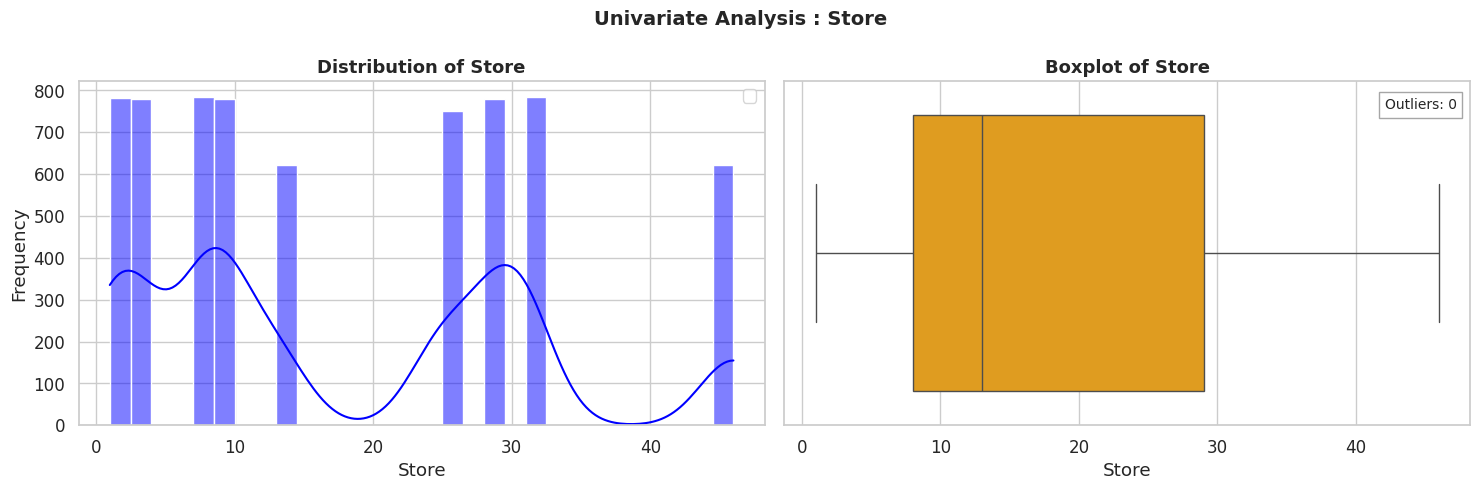

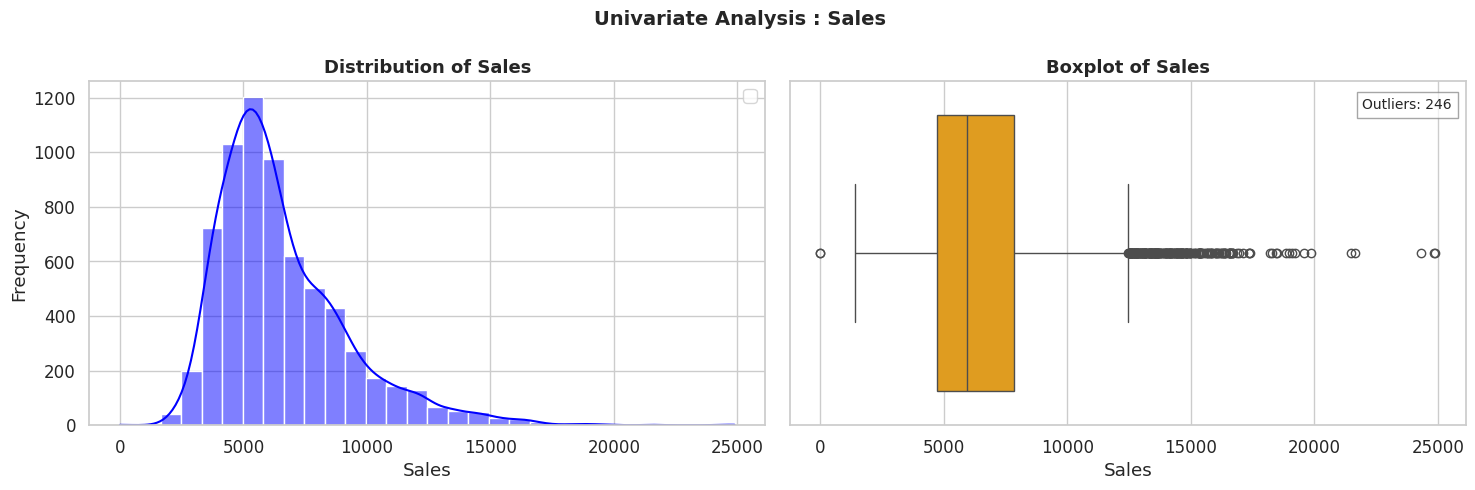

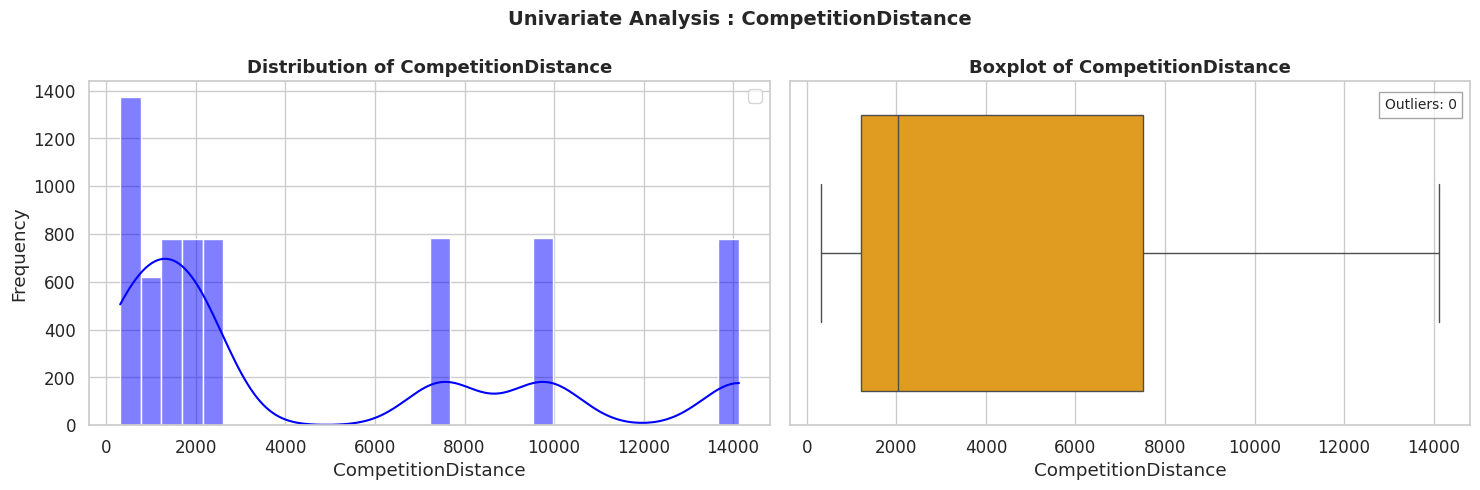

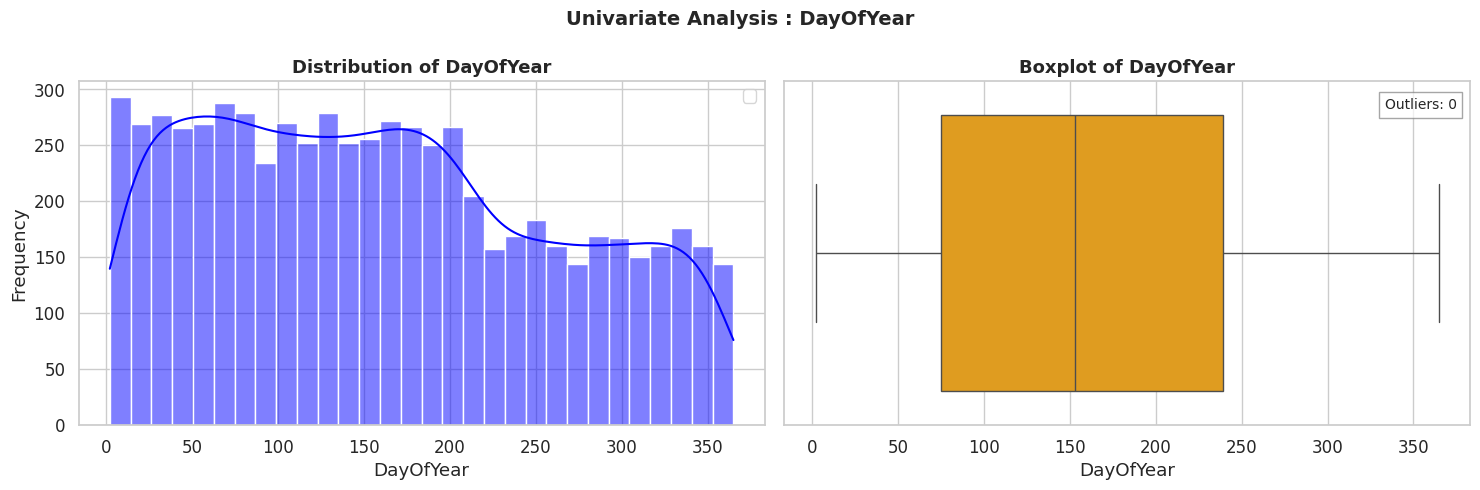

In [13]:
plot_univariate_numeric(df, num_cols, 30)

### 7.3 Univariate Analysis - Categorical Columns

In [14]:
def plot_univariate_categorical(df: pd.DataFrame, cat_cols: list):

    sns.set(style="whitegrid", font_scale=1.1)

    for col in cat_cols:

        vc = df[col].value_counts()
        total = vc.sum()
        order = vc.index

        plt.figure(figsize=(10, 5))

        # Barplot with better palette
        ax = sns.countplot(
            data=df,
            x=col,
            order=order,
            palette="viridis"
        )

        # Rotate x labels
        plt.xticks(rotation=45, ha='right')

        # Title
        plt.title(f"Univariate Categorical Distribution: {col}", fontsize=14, weight="bold")

        plt.xlabel(col)
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

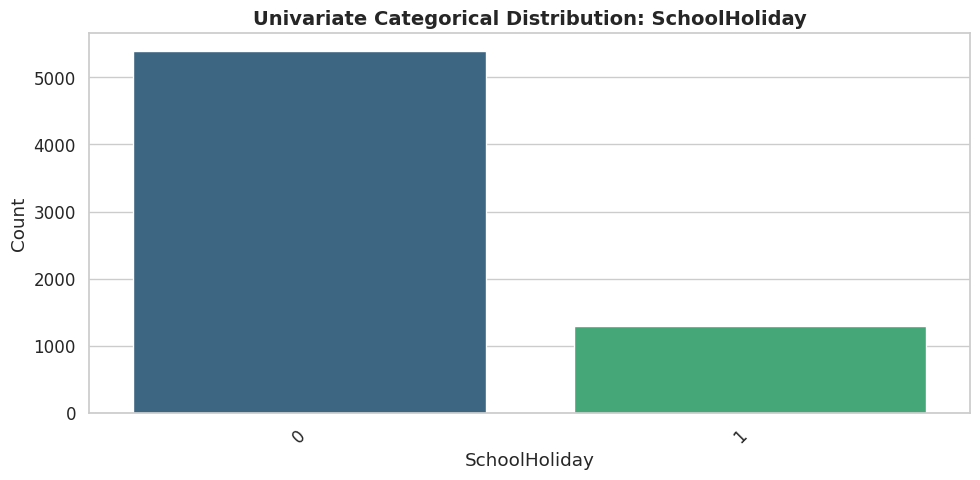

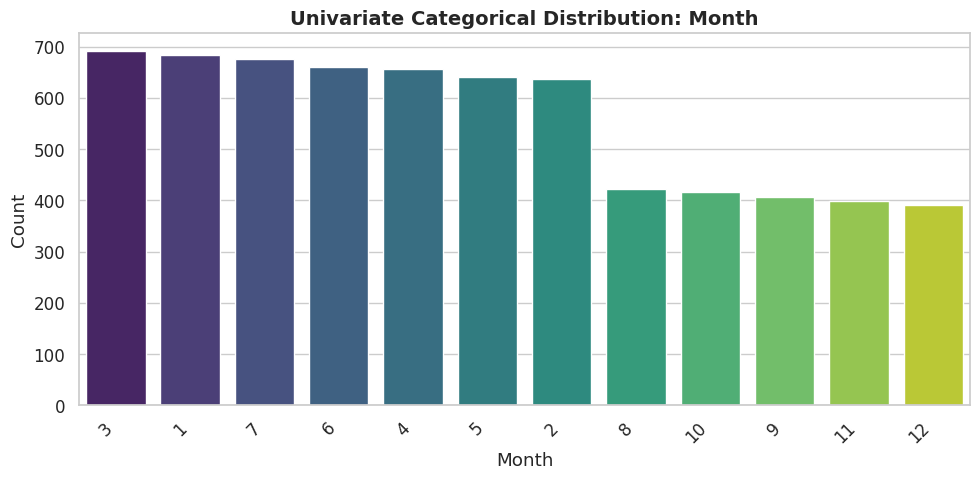

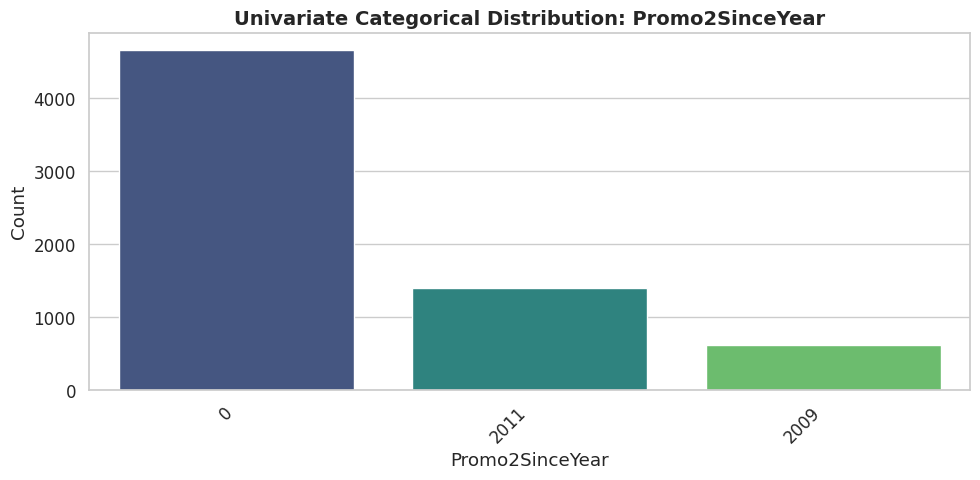

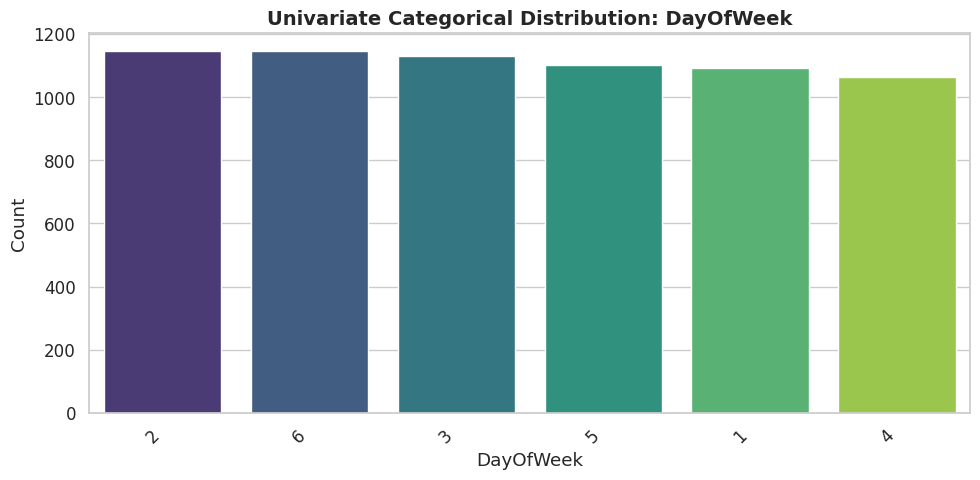

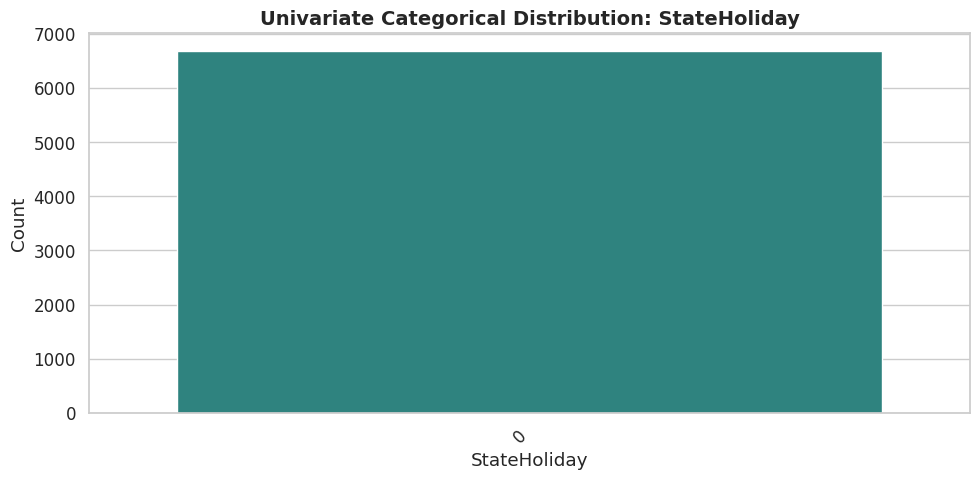

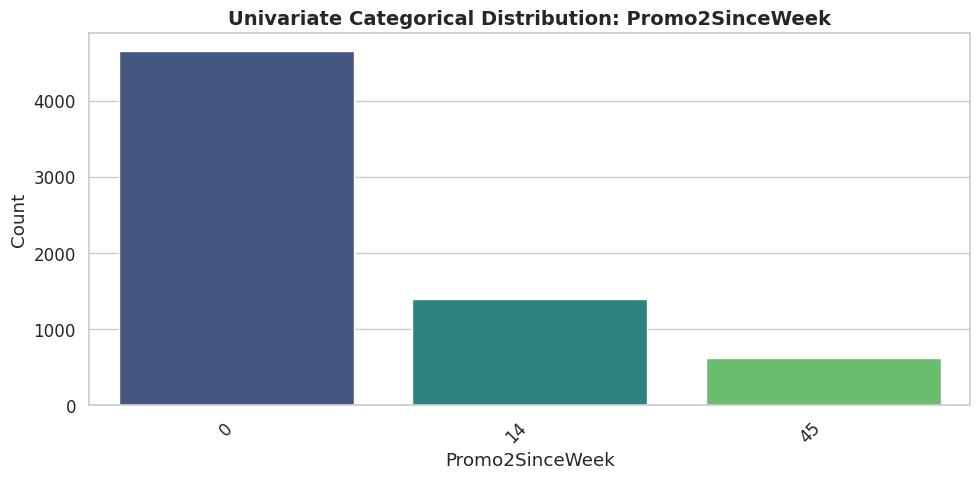

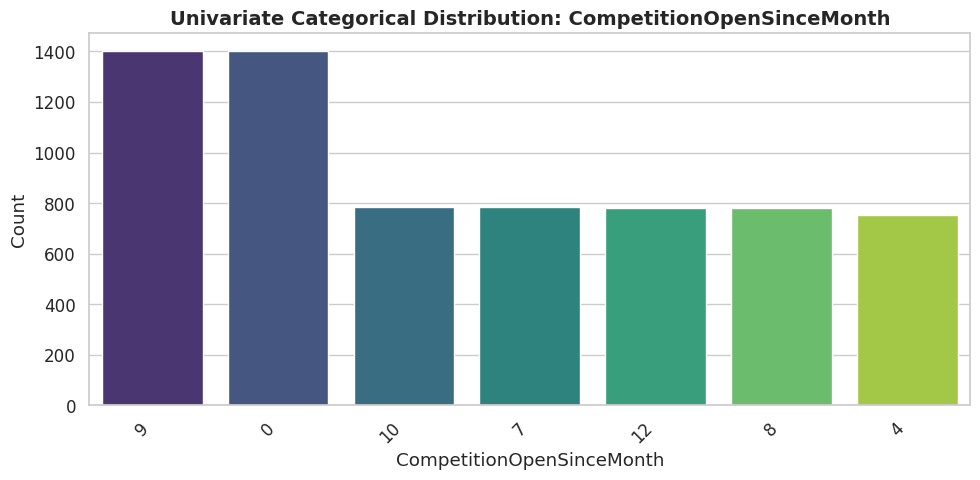

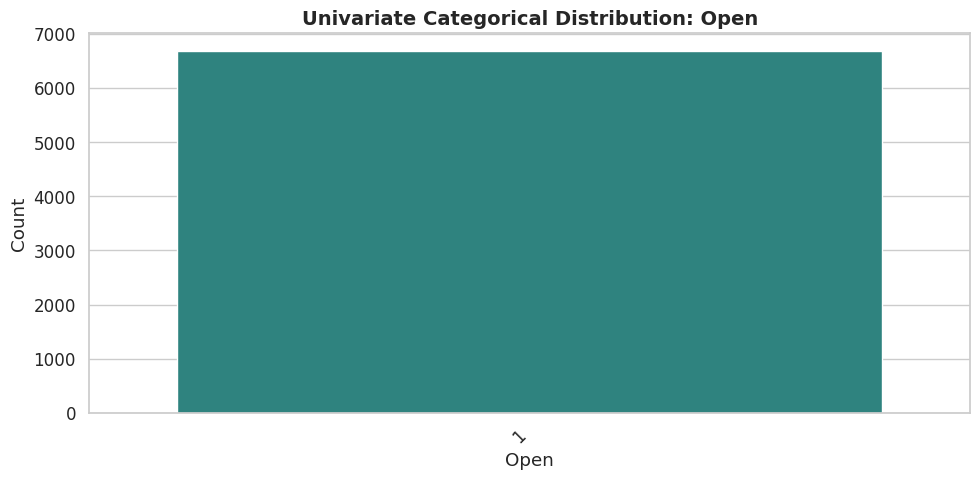

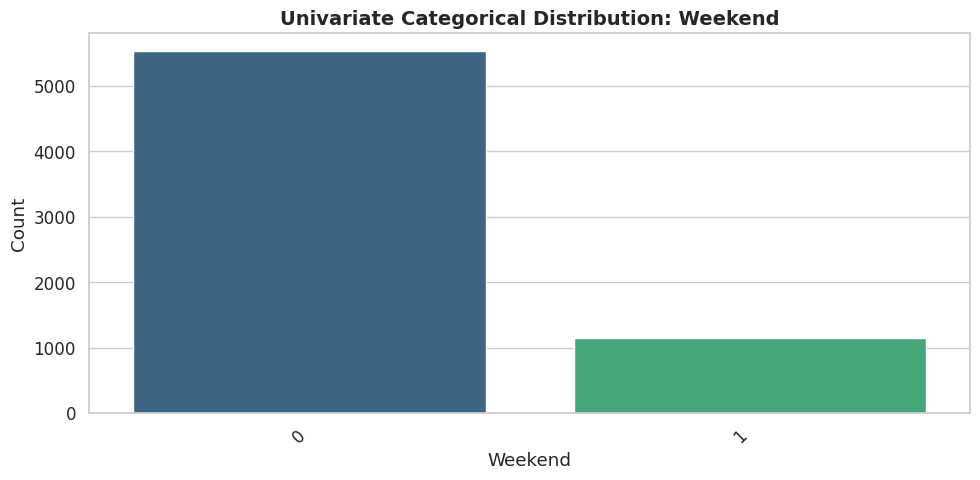

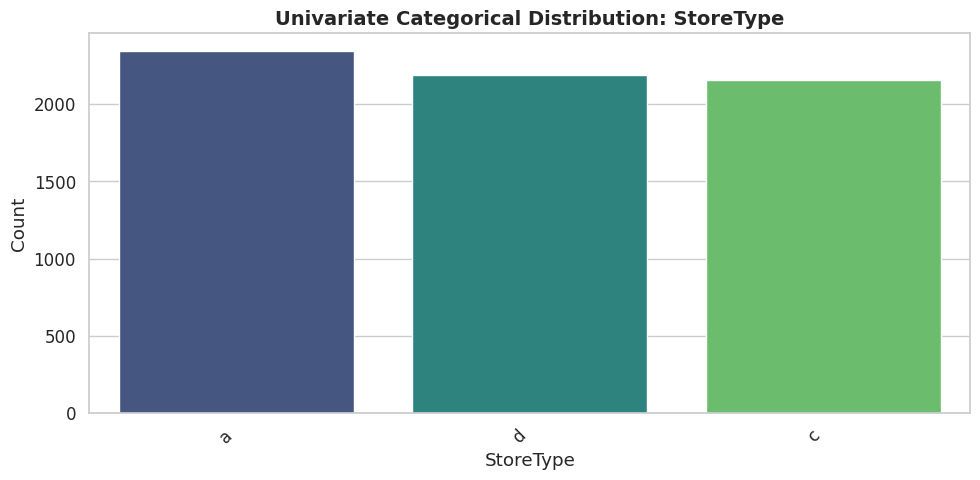

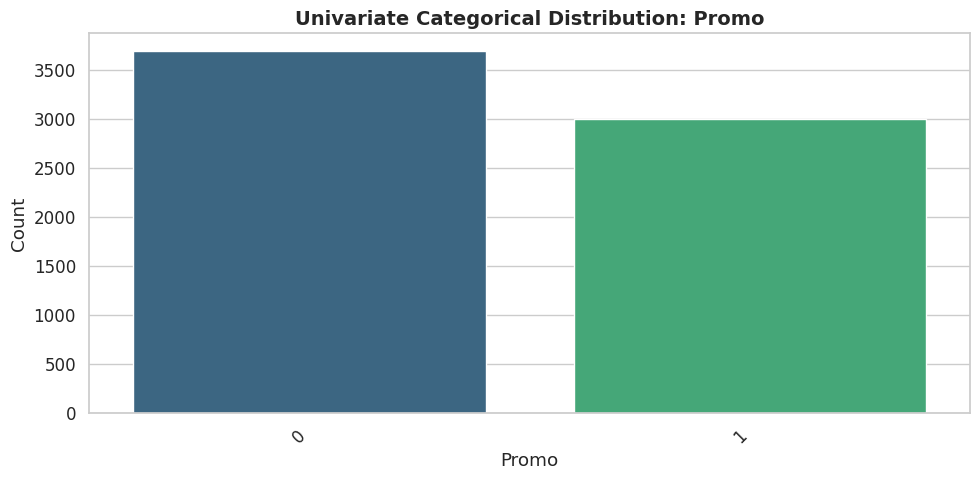

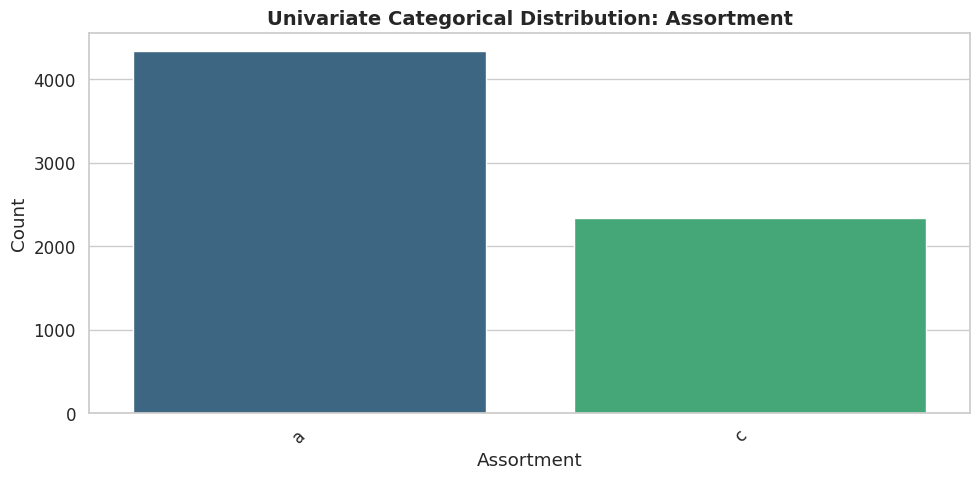

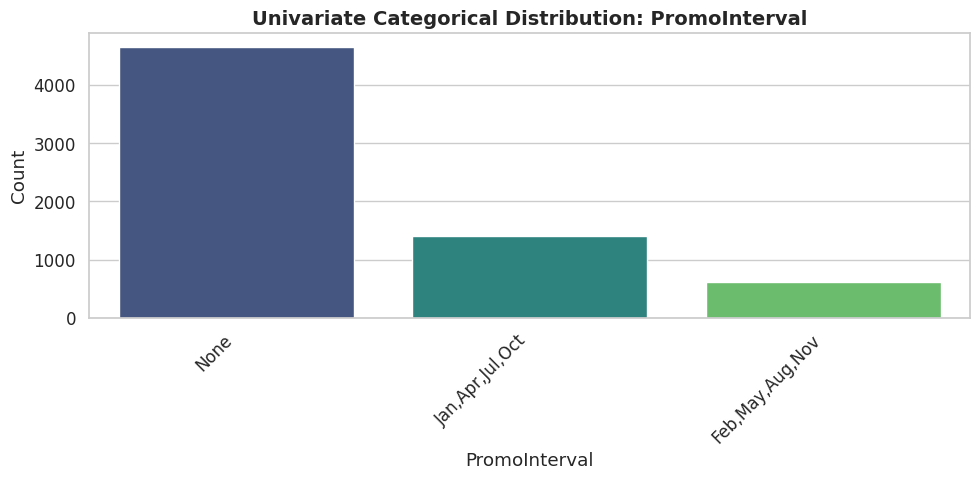

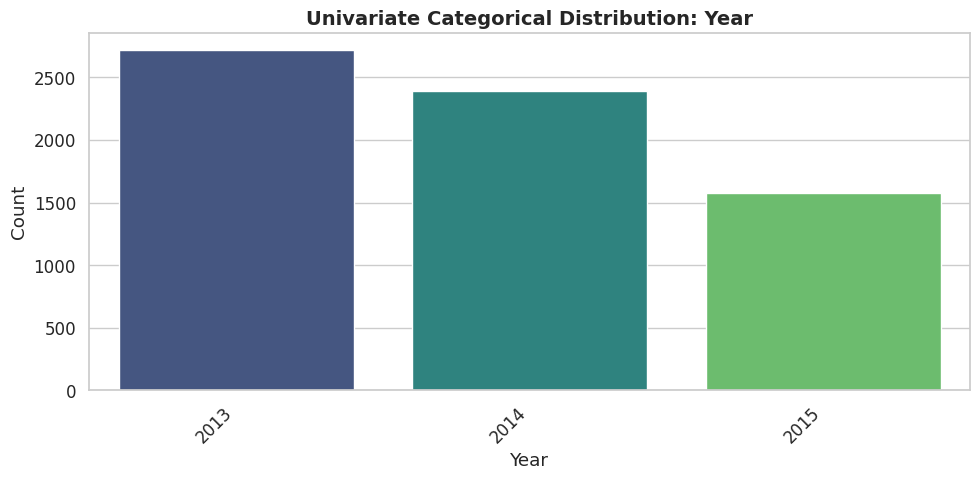

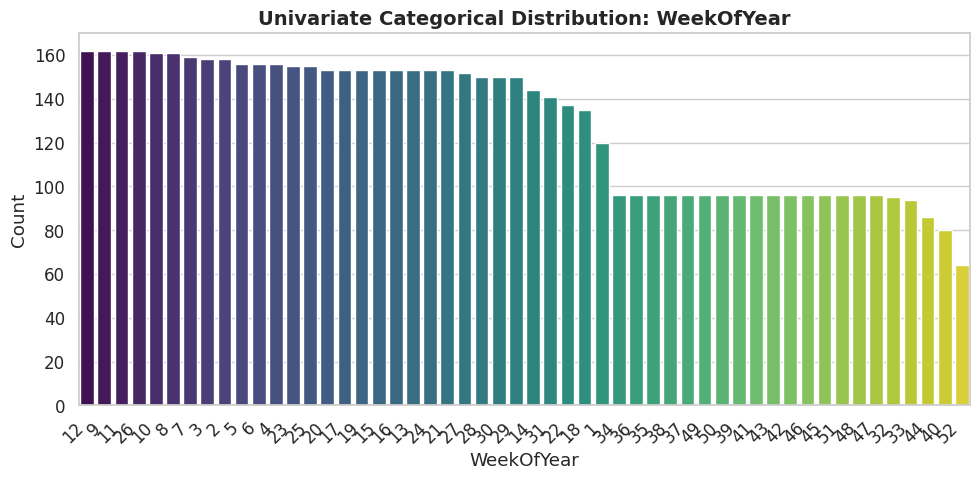

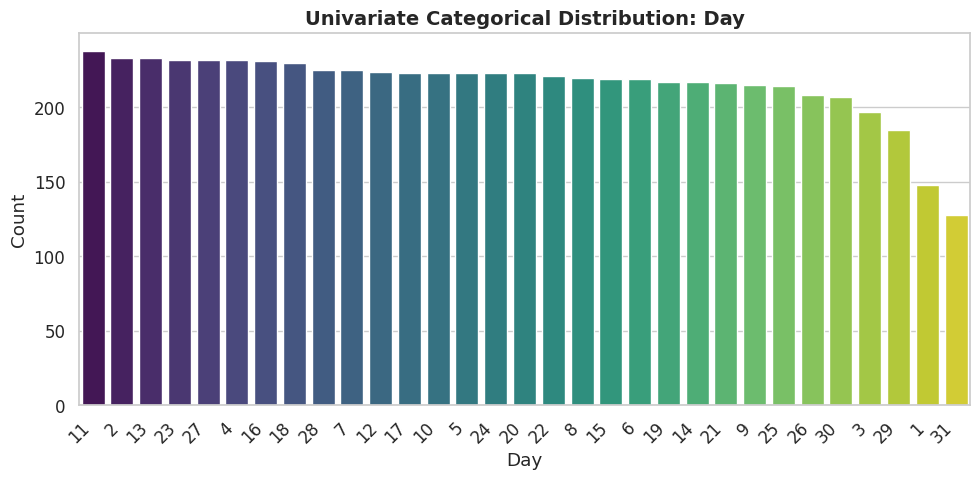

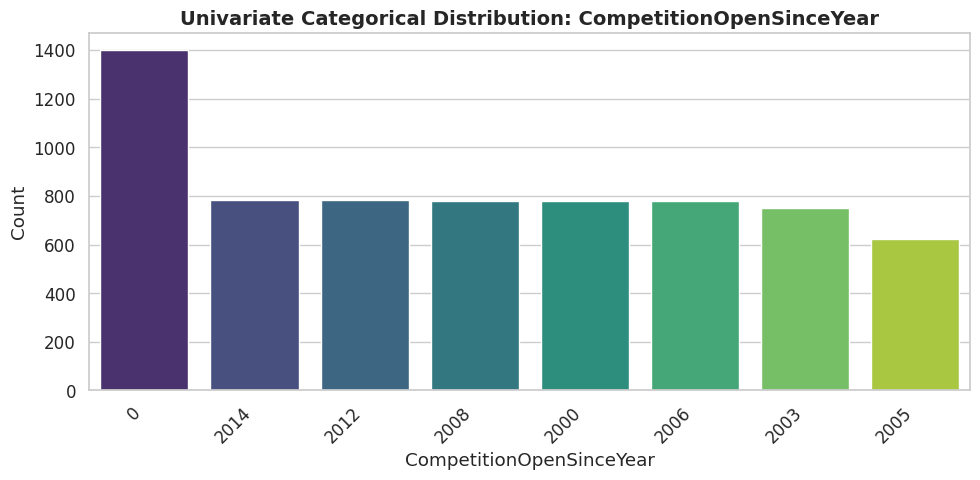

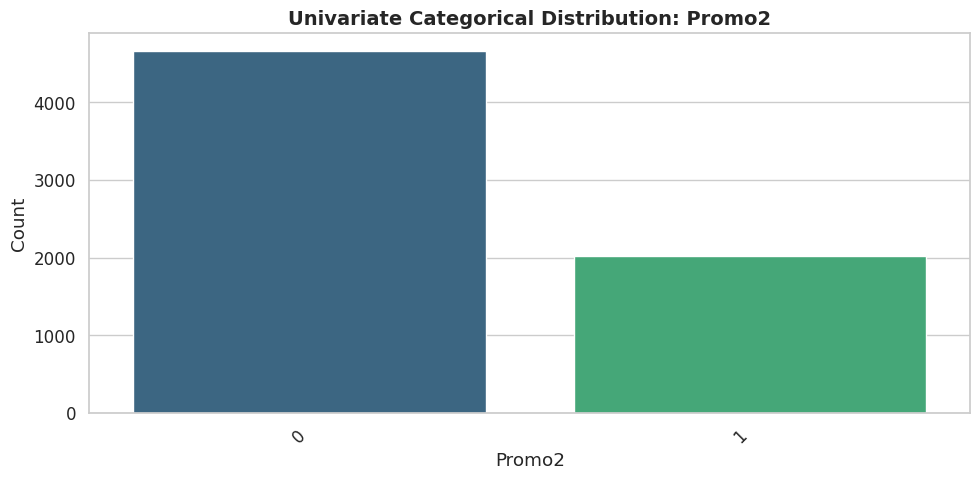

In [15]:
plot_univariate_categorical(df, cat_cols)

###7.4 Bivariate Analysis - Sales Focused

In [16]:
sns.set(style="whitegrid", font_scale=1.1)

def plot_sales_by_category(
    df: pd.DataFrame,
    cat_cols: list,
    sales_col: str = "Sales",
    hue: str = None,
    top_n_categories: int = None
):

    for col in cat_cols:

        if col not in df.columns:
            continue

        # Drop NaNs on relevant columns
        plot_df = df[[col, sales_col] + ([hue] if hue else [])].dropna()

        # Optionally limit to top N categories by frequency
        if top_n_categories is not None and plot_df[col].nunique() > top_n_categories:
            top_cats = plot_df[col].value_counts().nlargest(top_n_categories).index
            plot_df = plot_df[plot_df[col].isin(top_cats)]

        # Category order by median Sales (for nicer ordering)
        order = (plot_df.groupby(col)[sales_col].median().sort_values(ascending=False).index)

        # Create subplots: boxplot + barplot side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

        sns.boxplot(
            data=plot_df,
            x=col,
            y=sales_col,
            hue=hue,
            order=order,
            ax=axes[0]
        )
        axes[0].set_title(f"{sales_col} by {col} (distribution)")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel(sales_col)
        axes[0].tick_params(axis="x", rotation=30)

        # Move legend out of the way (only on left plot)
        if hue is not None:
            axes[0].legend(loc="upper right", title=hue)
        else:
            axes[0].legend_.remove() if axes[0].get_legend() else None

        sns.barplot(
            data=plot_df,
            x=col,
            y=sales_col,
            hue=hue,
            order=order,
            estimator=np.mean,
            ci=95,
            ax=axes[1]
        )
        axes[1].set_title(f"Mean {sales_col} by {col} (±95% CI)")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel(f"Mean {sales_col}")
        axes[1].tick_params(axis="x", rotation=30)

        if hue is not None:
            axes[1].legend(loc="upper right", title=hue)
        else:
            axes[1].legend_.remove() if axes[1].get_legend() else None

        plt.suptitle(f"{sales_col} vs {col}", y=1.03, fontsize=15)
        plt.tight_layout()
        plt.show()


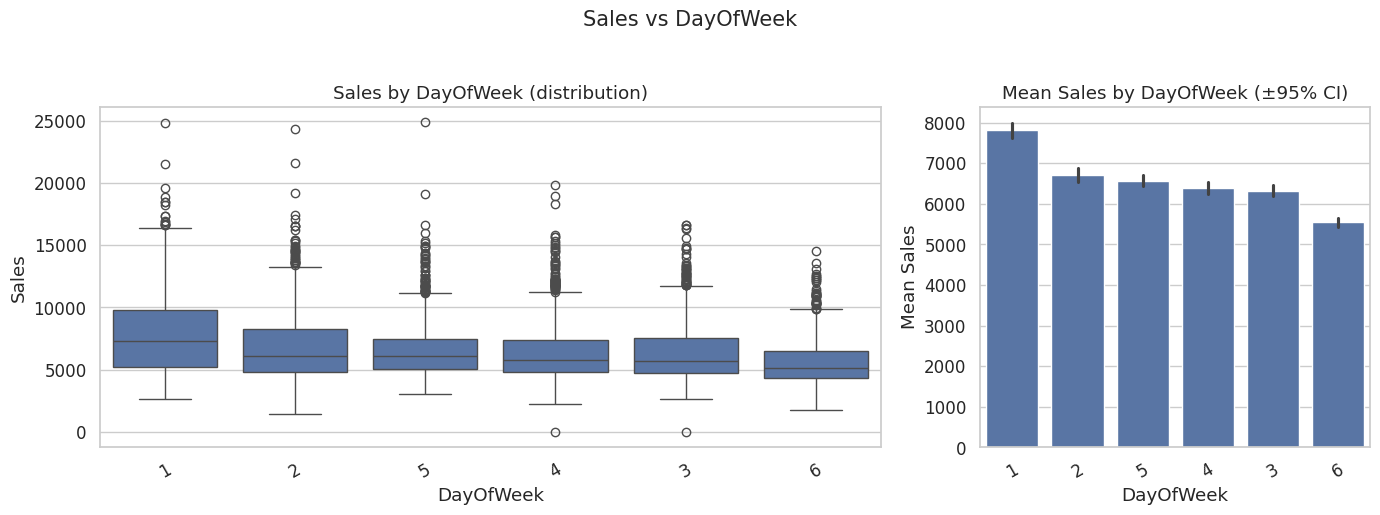

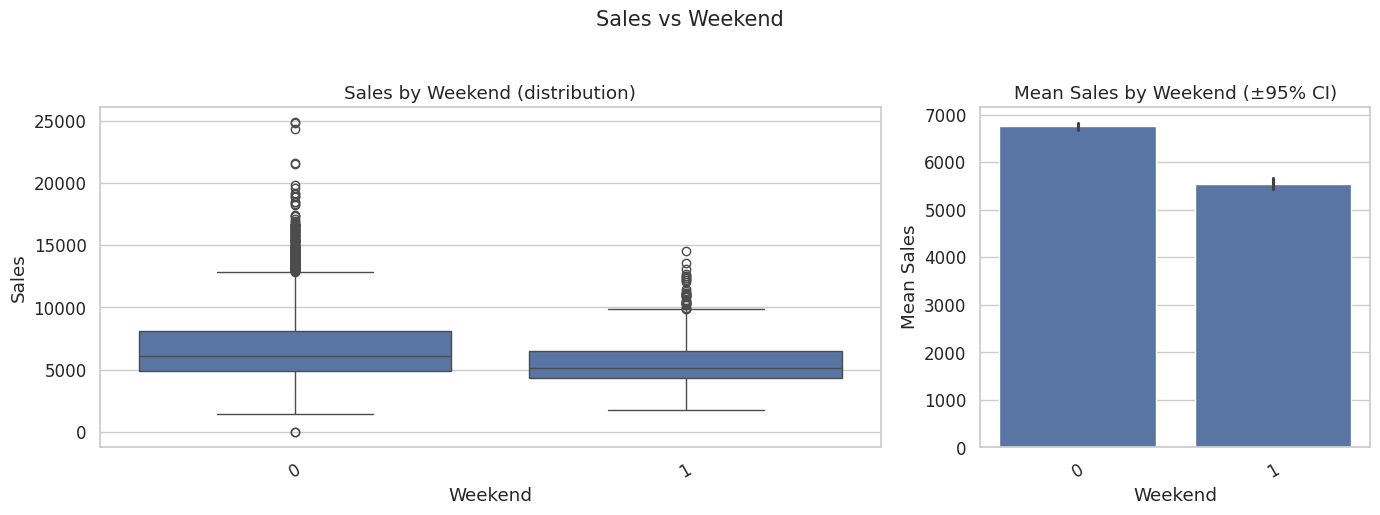

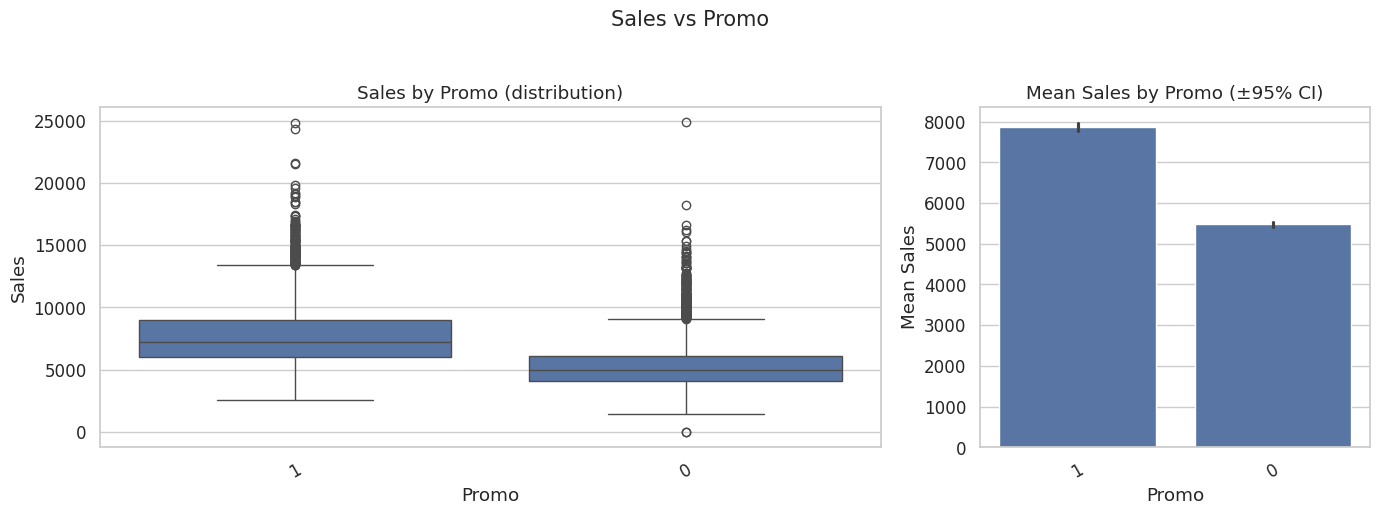

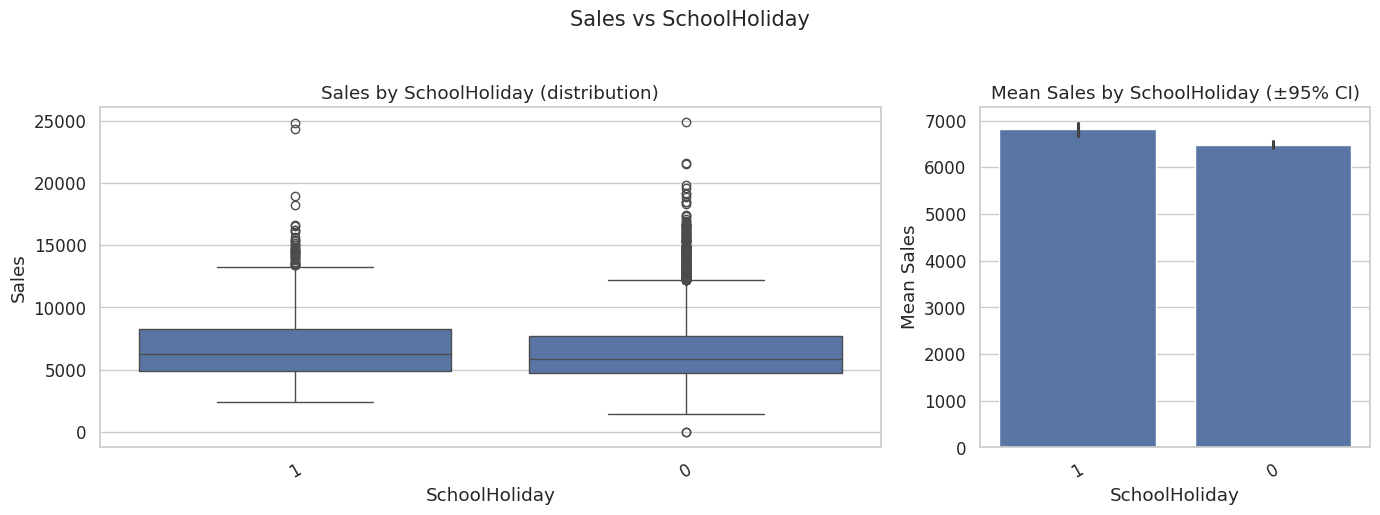

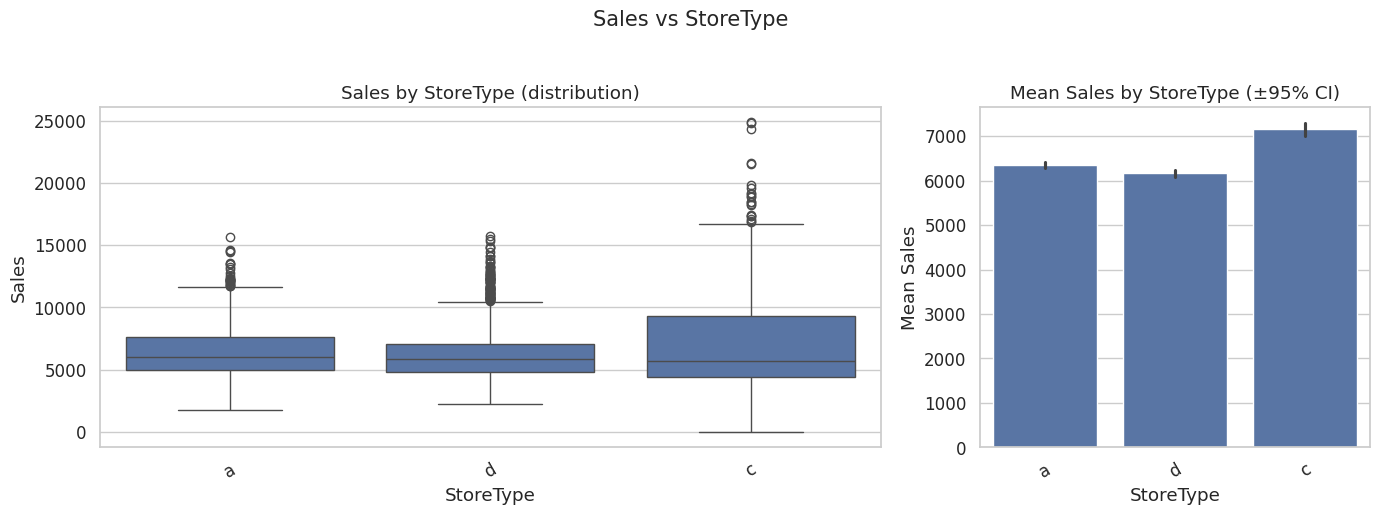

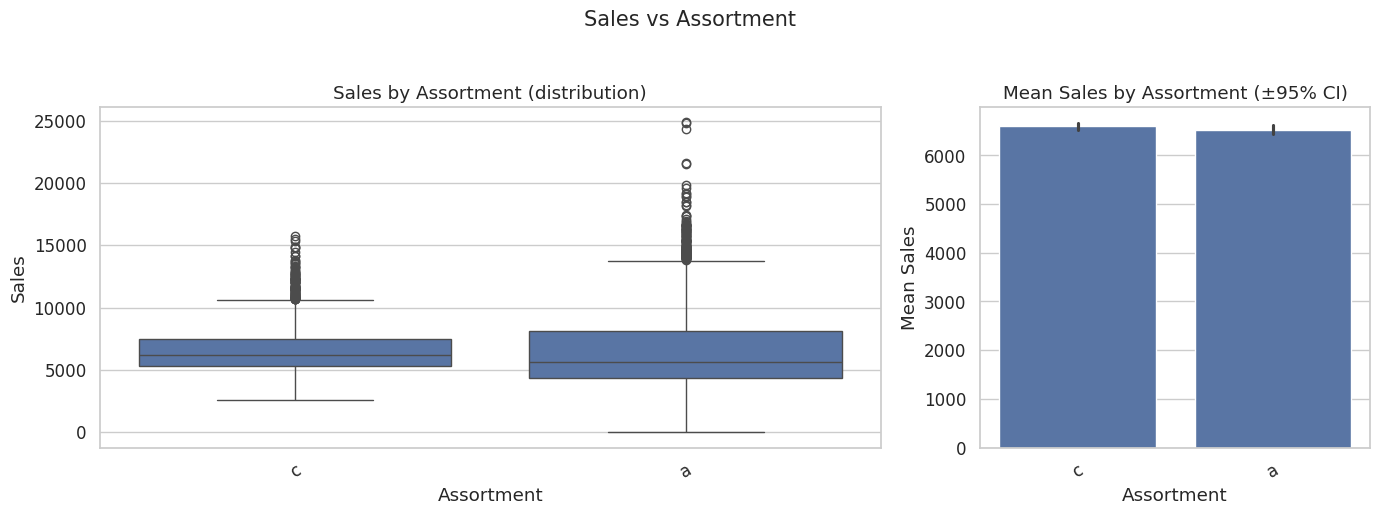

In [17]:
# Categories for clarity
cat_for_sales = [c for c in [
    "DayOfWeek", "Weekend", "Promo", "Promo2"
    "StateHoliday", "SchoolHoliday", "StoreType", "Assortment"
] if c in df.columns]

plot_sales_by_category(df, cat_for_sales, sales_col="Sales")

### 7.5 Coorelation HeatMap

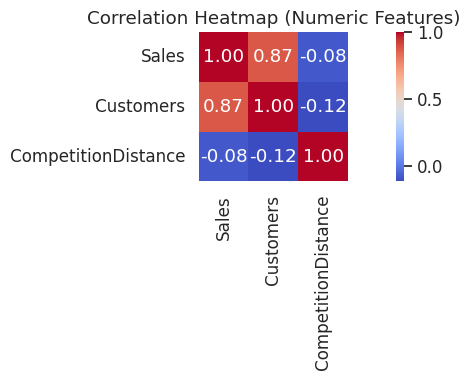

In [18]:
def plot_correlation_heatmap(df: pd.DataFrame, num_cols: list):
    corr_df = df[num_cols].corr()

    plt.figure(figsize=(10, 4))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# Choose a subset for clarity:
num_for_corr = [c for c in ["Sales", "Customers", "CompetitionDistance"] if c in df.columns]

plot_correlation_heatmap(df, num_for_corr)

## 8. Outlier Treatment (99th Percentile in Sales per Store)

In [19]:
def remove_outliers_99pct_sales(data):
    filtered = []
    for store_id, grp in data.groupby("Store"):
        g = grp.copy()
        thresh = g["Sales"].quantile(0.99)
        g = g[g["Sales"] <= thresh]
        filtered.append(g)
    return pd.concat(filtered, axis=0).sort_values(["Store", "Date"])

print("Shape before outlier removal:", df.shape)
df_clean = remove_outliers_99pct_sales(df)
print("Shape after outlier removal:", df_clean.shape)

df_clean.head()


Shape before outlier removal: (6681, 24)
Shape after outlier removal: (6611, 24)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,DayOfYear,Weekend
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,2,1,2,0
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,3,1,3,0
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,4,1,4,0
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,5,1,5,1
1009405,1,1,2013-01-07,7176,785,1,1,0,1,c,a,1270.0,9,2008,0,0,0,None,2013,1,7,2,7,0


## 9. Train / Test Split (Last 6 Weeks as Test)

In [20]:
FORECAST_HORIZON = 42  # 6 weeks ~ 42 days

def train_test_split_store(data, store_id, horizon=FORECAST_HORIZON):
    """Return train and test series for one store (Sales only here)."""
    g = data[data["Store"] == store_id].copy()
    g = g.sort_values("Date").set_index("Date")
    series = g["Sales"].asfreq("D")  # daily frequency (missing days as NaN)

    # Drop leading missing values if any
    series = series.dropna()

    if len(series) <= horizon + 10:
        raise ValueError(f"Not enough data for store {store_id}")

    train_series = series.iloc[:-horizon]
    test_series = series.iloc[-horizon:]

    return train_series, test_series

# Example for Store 1
example_store = 1
train_1, test_1 = train_test_split_store(df_clean, example_store)
print("Store 1 - train length:", len(train_1), "test length:", len(test_1))
train_1.tail(), test_1.head()


Store 1 - train length: 731 test length: 42


(Date
 2015-06-08    4071.0
 2015-06-09    4102.0
 2015-06-10    3591.0
 2015-06-11    3627.0
 2015-06-12    3695.0
 Name: Sales, dtype: float64,
 Date
 2015-06-13    4256.0
 2015-06-15    5518.0
 2015-06-16    4852.0
 2015-06-17    4000.0
 2015-06-18    4645.0
 Name: Sales, dtype: float64)

## 10. Model 1 — Naive Last-Value Forecast

In [21]:
def naive_last_value_forecast(train_series, horizon):
    """Forecast future values as the last observed value in the training set."""
    last_val = train_series.iloc[-1]
    return np.repeat(last_val, horizon)

# Example for Store 1
naive_forecast_1 = naive_last_value_forecast(train_1, len(test_1))
naive_mape_1 = mean_absolute_percentage_error(test_1.values, naive_forecast_1)
print(f"Naive last-value MAPE (Store {example_store}): {naive_mape_1:.2f}%")


Naive last-value MAPE (Store 1): 16.30%


## 11. Model 2 — ARIMA

In [22]:
def arima_forecast(train_series, horizon, max_p=3, max_d=3, max_q=3):
    """Fit a simple ARIMA model and forecast horizon steps ahead."""
    best_order_model = None
    best_aic = np.inf
    best_order = None
    best_fit  = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):

                if p == d == q == 0:
                    continue
                model = ARIMA(train_series, order=(p,d,q))
                fitted = model.fit()

                if fitted.aic < best_aic:
                      best_aic = fitted.aic
                      best_order = (p, d, q)
                      best_order_model = model
                      best_fit = fitted

    print(f"Best params: {best_order}")
    return best_fit.forecast(steps=horizon), best_order

# Check stationarity (optional)
adf_test(train_1, title=f"Store {example_store} - Sales (level)")

# Example ARIMA(1,1,1) for Store 1
arima_forecast_1, arima_best_order = arima_forecast(train_1, len(test_1), max_p=3, max_d=3, max_q=3)
arima_mape_1 = mean_absolute_percentage_error(test_1.values, arima_forecast_1.values)
print(f"ARIMA{arima_best_order} MAPE (Store {example_store}): {arima_mape_1:.2f}%")



ADF Test: Store 1 - Sales (level)
ADF Statistic: -5.545200190805924
p-value: 1.666935594895687e-06
# Lags Used: 13
# Observations Used: 717
Critical Value 1%: -3.439503230053971
Critical Value 5%: -2.8655794463678346
Critical Value 10%: -2.5689210707289982
=> Likely STATIONARY (reject H0)
Best params: (3, 1, 3)
ARIMA(3, 1, 3) MAPE (Store 1): 15.39%


## 12. Model 3 — SARIMA (Seasonal Weekly Pattern)

In [23]:
def sarima_forecast(train_series, horizon, max_p=3, max_d=3, max_q=3, seasonal_order=(1, 1, 1, 7)):
    """Fit a simple SARIMA model and forecast horizon steps ahead."""
    best_order_model = None
    best_aic = np.inf
    best_order = None
    best_fit  = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
               if p == d == q == 0:
                    continue

               model = sm.tsa.statespace.SARIMAX(
                    train_series,
                    order=(p,d,q),
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
               )
               fitted = model.fit(disp=False)

               if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_order_model = model
                        best_fit = fitted

    forecast = best_fit.forecast(steps=horizon)
    return forecast, best_order

sarima_forecast_1, sarima_best_order = sarima_forecast(
    train_1,
    len(test_1),
    max_p=3,
    max_q=3,
    max_d=3,
    seasonal_order=(1, 1, 1, 7)
)
sarima_mape_1 = mean_absolute_percentage_error(test_1.values, sarima_forecast_1.values)
print(f"SARIMA {sarima_best_order} MAPE (Store {example_store}): {sarima_mape_1:.2f}%")


SARIMA (2, 1, 3) MAPE (Store 1): 14.51%


## 14. Model 4 — SARIMAX (with Promo & Holidays as Exogenous Variables)

In [24]:
def prepare_exog(data, store_id):
    """Prepare exogenous regressors (Promo, SchoolHoliday) for SARIMAX, aligned with Sales series."""
    g = data[data["Store"] == store_id].copy()
    g = g.sort_values("Date").set_index("Date")
    g = g.asfreq("D")

    # Fill exogenous missing values (holidays & promos) forward/backward reasonably
    for col in ["Promo", "SchoolHoliday"]:
        if col in g.columns:
            g[col] = g[col].fillna(0)

    # Make sure Sales is consistent with train/test series
    exog = g[["Promo", "SchoolHoliday"]].copy()
    return exog

exog_1 = prepare_exog(df_clean, example_store)

def sarimax_forecast(train_series, test_series, exog_all, max_p=3, max_d=3, max_q=3, seasonal_order=(1, 1, 1, 7)):
    """Fit SARIMAX with exogenous regressors and forecast test horizon."""
    # Align exog with full series index
    full_index = train_series.index.append(test_series.index)
    exog_all = exog_all.reindex(full_index).fillna(0)

    exog_train = exog_all.loc[train_series.index]
    exog_test = exog_all.loc[test_series.index]

    best_order_model = None
    best_aic = np.inf
    best_order = None
    best_fit  = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
                if p == d == q == 0:
                    continue

                model = SARIMAX(
                    train_series,
                    exog=exog_train,
                    order=(p,d,q),
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                fitted = model.fit(disp=False)

                if fitted.aic < best_aic:
                      best_aic = fitted.aic
                      best_order = (p, d, q)
                      best_order_model = model
                      best_fit = fitted

    forecast = best_fit.forecast(steps=len(test_series), exog=exog_test)
    return forecast, best_order

sarimax_forecast_1, sarimax_best_order = sarimax_forecast(
    train_1, test_1, exog_1, max_p=3, max_d=3, max_q=3, seasonal_order=(1, 1, 1, 7)
)
sarimax_mape_1 = mean_absolute_percentage_error(test_1.values, sarimax_forecast_1.values)
print(f"SARIMAX {sarimax_best_order} MAPE (Store {example_store}): {sarimax_mape_1:.2f}%")


SARIMAX (2, 1, 3) MAPE (Store 1): 11.14%


## 15. Model 5 — VAR / VECM (Multivariate: Sales, Customers, Promo, Promo2)

In [25]:
def prepare_var_data(data, store_id):
    """Prepare multivariate dataframe for VAR/VECM for one store."""
    g = data[data["Store"] == store_id].copy()
    g = g.sort_values("Date").set_index("Date")
    g = g.asfreq("D")

    # Keep core variables (some may not exist in sample)
    cols = []
    for c in ["Sales", "Customers", "Promo"]:
        if c in g.columns:
            cols.append(c)
    df_var = g[cols].copy()

    # Simple missing handling
    df_var["Sales"] = df_var["Sales"].interpolate().bfill().ffill()
    if "Customers" in df_var.columns:
        df_var["Customers"] = df_var["Customers"].interpolate().bfill().ffill()
    for c in ["Promo", "Promo2"]:
        if c in df_var.columns:
            df_var[c] = df_var[c].fillna(0)

    return df_var

var_data_1 = prepare_var_data(df_clean, example_store)
var_data_1.tail()


,Sales,Customers,Promo
Date,,,
2015-07-27,6102.0,612.0,1.0
2015-07-28,5011.0,560.0,1.0
2015-07-29,4782.0,523.0,1.0
2015-07-30,5020.0,546.0,1.0
2015-07-31,5263.0,555.0,1.0


In [26]:
# Check stationarity and cointegration on levels
adf_test(var_data_1["Sales"], title=f"Store {example_store} - Sales (VAR level)")

if "Customers" in var_data_1.columns:
    adf_test(var_data_1["Customers"], title=f"Store {example_store} - Customers (VAR level)")

if var_data_1.shape[1] >= 2:
    rank_1 = johansen_cointegration_test(var_data_1, var_data_1.columns.tolist())
else:
    rank_1 = 0


ADF Test: Store 1 - Sales (VAR level)
ADF Statistic: -5.162766675575857
p-value: 1.0468752581852943e-05
# Lags Used: 17
# Observations Used: 923
Critical Value 1%: -3.437454636606558
Critical Value 5%: -2.8646764401027336
Critical Value 10%: -2.5684400361180333
=> Likely STATIONARY (reject H0)

ADF Test: Store 1 - Customers (VAR level)
ADF Statistic: -4.086396479876079
p-value: 0.001019903253778123
# Lags Used: 21
# Observations Used: 919
Critical Value 1%: -3.437485646962348
Critical Value 5%: -2.8646901138095378
Critical Value 10%: -2.568447319459459
=> Likely STATIONARY (reject H0)

Johansen Cointegration Test (Trace Statistics):
Trace statistics: [574.06623209 283.75504252 109.44937915]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated cointegration rank (at 5%): 3


In [27]:
def var_vecm_forecast_sales(var_df, horizon=FORECAST_HORIZON):
    """
    Fit VECM if cointegration rank > 0, else VAR, and forecast Sales.

    Returns:
        forecast_index: DatetimeIndex for forecast horizon
        sales_forecast: np.array of Sales forecasts
    """
    # Train/test split by index for multivariate series
    if len(var_df) <= horizon + 10:
        raise ValueError("Not enough data for VAR/VECM")

    train_df = var_df.iloc[:-horizon]
    test_df = var_df.iloc[-horizon:]

    cols = train_df.columns.tolist()

    # Standardize variables (helps VAR/VECM stability)
    scaler = StandardScaler()
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_df), index=train_df.index, columns=cols
    )
    test_scaled = pd.DataFrame(
        scaler.transform(test_df), index=test_df.index, columns=cols
    )

    # Estimate cointegration rank
    rank = 0
    if len(cols) >= 2:
        try:
            rank = johansen_cointegration_test(train_scaled, cols)
        except Exception as e:
            print("Johansen test failed, falling back to VAR. Error:", e)
            rank = 0

    # If there is cointegration -> VECM
    if rank > 0:
        print(f"Using VECM with rank={rank}")
        vecm_model = VECM(train_scaled, k_ar_diff=1, coint_rank=rank, deterministic="ci")
        vecm_res = vecm_model.fit()
        #forecast_scaled = vecm_res.predict(train_scaled.values[-vecm_model.k_ar_diff:], steps=horizon)
        forecast_scaled = vecm_res.predict(steps=horizon)
        forecast_scaled = pd.DataFrame(forecast_scaled, columns=cols, index=test_df.index)
    else:
        print("Using VAR (no cointegration or test failed)")
        var_model = VAR(train_scaled)
        sel = var_model.select_order(maxlags=7)
        if hasattr(sel.aic, "idxmin"):
            p = sel.aic.idxmin()
        else:
            p = 1
        print("Selected VAR lag (AIC):", p)
        var_res = var_model.fit(p)
        #forecast_scaled = var_res.predict(train_scaled.values[-p:], steps=horizon)
        forecast_scaled = var_res.predict(steps=horizon)
        forecast_scaled = pd.DataFrame(forecast_scaled, columns=cols, index=test_df.index)

    # Inverse scaling to original units
    forecast_orig = pd.DataFrame(
        scaler.inverse_transform(forecast_scaled), index=test_df.index, columns=cols
    )

    return test_df.index, forecast_orig["Sales"].values, test_df["Sales"].values

# Example VAR/VECM forecast for Store 1
idx_1, var_forecast_sales_1, var_actual_sales_1 = var_vecm_forecast_sales(var_data_1, horizon=len(test_1))
var_mape_1 = mean_absolute_percentage_error(var_actual_sales_1, var_forecast_sales_1)
print(f"VAR/VECM Sales MAPE (Store {example_store}): {var_mape_1:.2f}%")



Johansen Cointegration Test (Trace Statistics):
Trace statistics: [552.94956193 277.14961549 106.59153938]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated cointegration rank (at 5%): 3
Using VECM with rank=3
VAR/VECM Sales MAPE (Store 1): 15.28%


## 16. Compare Models Across All Key Stores

In [28]:
results = []

for store_id in KEY_STORES:
    print(f"\n================ Store {store_id} ================")
    try:
        # 1. Univariate train/test
        train_s, test_s = train_test_split_store(df_clean, store_id)

        # 2. Naive
        naive_pred = naive_last_value_forecast(train_s, len(test_s))
        naive_mape = mean_absolute_percentage_error(test_s.values, naive_pred)

        # 3. ARIMA
        try:
            arima_pred, arima_best_order = arima_forecast(train_s, len(test_s), max_p=3, max_d=3, max_q=3)
            arima_mape = mean_absolute_percentage_error(test_s.values, arima_pred.values)
        except Exception as e:
            print("ARIMA failed:", e)
            arima_mape = np.nan

        # 4. SARIMA
        try:
            sarima_pred, sarima_best_order = sarima_forecast(train_s, len(test_s), max_p=3, max_d=3, max_q=3)
            sarima_mape = mean_absolute_percentage_error(test_s.values, sarima_pred.values)
        except Exception as e:
            print("SARIMA failed:", e)
            sarima_mape = np.nan

        # 5. SARIMAX
        try:
            exog_store = prepare_exog(df_clean, store_id)
            sarimax_pred, sarimax_best_order = sarimax_forecast(
                train_s, test_s, exog_store, max_p=3, max_d=3, max_q=3, seasonal_order=(1, 1, 1, 7)
            )
            sarimax_mape = mean_absolute_percentage_error(test_s.values, sarimax_pred.values)
        except Exception as e:
            print("SARIMAX failed:", e)
            sarimax_mape = np.nan

        # 6. VAR/VECM
        try:
            var_df = prepare_var_data(df_clean, store_id)
            _, var_forecast_sales, var_actual_sales = var_vecm_forecast_sales(
                var_df, horizon=len(test_s)
            )
            var_mape = mean_absolute_percentage_error(var_actual_sales, var_forecast_sales)
        except Exception as e:
            print("VAR/VECM failed:", e)
            var_mape = np.nan

        results.append(
            {
                "Store": store_id,
                "Naive_MAPE": naive_mape,
                "ARIMA_MAPE": arima_mape,
                "ARIMA_BEST_ORDER": arima_best_order,
                "SARIMA_MAPE": sarima_mape,
                "SARIMA_BEST_ORDER": sarima_best_order,
                "SARIMAX_MAPE": sarimax_mape,
                "SARIMAX_BEST_ORDER": sarimax_best_order,
                "VAR_VECM_MAPE": var_mape,
            }
        )
    except Exception as e:
        print(f"Skipping store {store_id} due to error:", e)

results_df = pd.DataFrame(results)
print("\nModel comparison (MAPE %, lower is better):")
display(results_df)



================ Store 1 ================
Best params: (3, 1, 3)

Johansen Cointegration Test (Trace Statistics):
Trace statistics: [552.94956193 277.14961549 106.59153938]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated cointegration rank (at 5%): 3
Using VECM with rank=3

================ Store 3 ================
Best params: (2, 0, 3)

Johansen Cointegration Test (Trace Statistics):
Trace statistics: [814.14694342 369.61244202 145.96126645]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated cointegration rank (at 5%): 3
Using VECM with rank=3

================ Store 8 ================
Best params: (3, 1, 3)

Johansen Cointegration Test (Trace Statistics):
Trace statistics: [1017.70885103  363.46714204  136.34875787]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
E

,Store,Naive_MAPE,ARIMA_MAPE,ARIMA_BEST_ORDER,SARIMA_MAPE,SARIMA_BEST_ORDER,SARIMAX_MAPE,SARIMAX_BEST_ORDER,VAR_VECM_MAPE
0,1,16.296754,15.393413,"(3, 1, 3)",14.512761,"(2, 1, 3)",11.135380,"(2, 1, 3)",15.283197
1,3,23.066129,19.979326,"(2, 0, 3)",24.271462,"(0, 1, 3)",13.757802,"(1, 0, 3)",23.421828
2,8,26.603422,27.345179,"(3, 1, 3)",28.231565,"(0, 1, 3)",15.979153,"(3, 0, 2)",24.553223
3,9,15.927876,17.284697,"(2, 1, 2)",18.692840,"(0, 1, 3)",14.610751,"(0, 1, 3)",15.182140
4,13,28.463169,21.888356,"(2, 0, 3)",22.631864,"(3, 0, 3)",16.286195,"(1, 1, 3)",33.457893
5,25,16.739189,18.250413,"(3, 1, 3)",17.734158,"(2, 0, 2)",14.316953,"(1, 0, 3)",15.947065
6,29,18.942974,21.089336,"(3, 1, 3)",22.738813,"(0, 1, 3)",16.109488,"(0, 1, 3)",15.444876
7,31,15.239159,285686.751933,"(1, 3, 3)",15.910951,"(1, 0, 3)",8.734184,"(1, 0, 3)",15.663158
8,46,19.638584,13.681433,"(3, 0, 3)",20.213621,"(2, 0, 3)",16.908053,"(0, 1, 3)",22.428860


## 17. Final 6-Week-Ahead Forecast (Using Best Model per Store)

In [29]:
def get_best_model_for_store(row):
    """Return the name of the model with the lowest MAPE and the corresponding best order for a given row."""

    # Define model metrics and their corresponding best orders
    metrics = {
        "Naive": (row["Naive_MAPE"], None),
        "ARIMA": (row["ARIMA_MAPE"], row["ARIMA_BEST_ORDER"]),
        "SARIMA": (row["SARIMA_MAPE"], row["SARIMA_BEST_ORDER"]),
        "SARIMAX": (row["SARIMAX_MAPE"], row["SARIMAX_BEST_ORDER"]),
        "VAR_VECM": (row["VAR_VECM_MAPE"], None),
    }

    # Remove NaNs from metrics
    metrics = {k: v for k, v in metrics.items() if not pd.isna(v[0])}

    if not metrics:
        return None, None

    # Find the best model based on the minimum MAPE
    best_model, (best_mape, best_order) = min(metrics.items(), key=lambda x: x[1][0])

    return best_model, best_order

if not results_df.empty:
    # Apply the function to each row and create two new columns: 'Best_Model' and 'Best_Order'
    results_df[["Best_Model", "Best_Order"]] = results_df.apply(get_best_model_for_store, axis=1, result_type="expand")

    # Display the results
    print("Best model and order per store:")
    display(results_df[["Store", "Best_Model", "Best_Order"]])
else:
    print("No results to choose best model from.")



Best model and order per store:


,Store,Best_Model,Best_Order
0,1,SARIMAX,"(2, 1, 3)"
1,3,SARIMAX,"(1, 0, 3)"
2,8,SARIMAX,"(3, 0, 2)"
3,9,SARIMAX,"(0, 1, 3)"
4,13,SARIMAX,"(1, 1, 3)"
5,25,SARIMAX,"(1, 0, 3)"
6,29,VAR_VECM,None
7,31,SARIMAX,"(1, 0, 3)"
8,46,ARIMA,"(3, 0, 3)"


Best model for Store 1 is: SARIMAX

Future 6-week forecast for Store 1


,Store,Date,Sales_Forecast
0,1,2015-08-01,4872.091849
1,1,2015-08-02,4703.474397
2,1,2015-08-03,4566.533859
3,1,2015-08-04,4493.015063
4,1,2015-08-05,4586.665739
5,1,2015-08-06,4643.629871
6,1,2015-08-07,4561.177841
7,1,2015-08-08,4638.821354
8,1,2015-08-09,4645.407706
9,1,2015-08-10,4575.368991


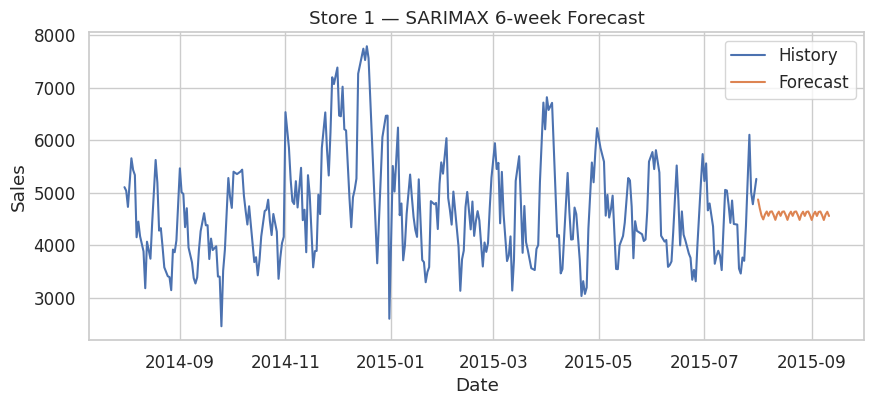

Best model for Store 3 is: SARIMAX

Future 6-week forecast for Store 3


,Store,Date,Sales_Forecast
0,3,2015-08-01,4599.585016
1,3,2015-08-02,4677.369979
2,3,2015-08-03,4925.773055
3,3,2015-08-04,4646.308519
4,3,2015-08-05,4952.433444
5,3,2015-08-06,4797.317302
6,3,2015-08-07,4989.028726
7,3,2015-08-08,4907.982761
8,3,2015-08-09,4905.797357
9,3,2015-08-10,5055.649923


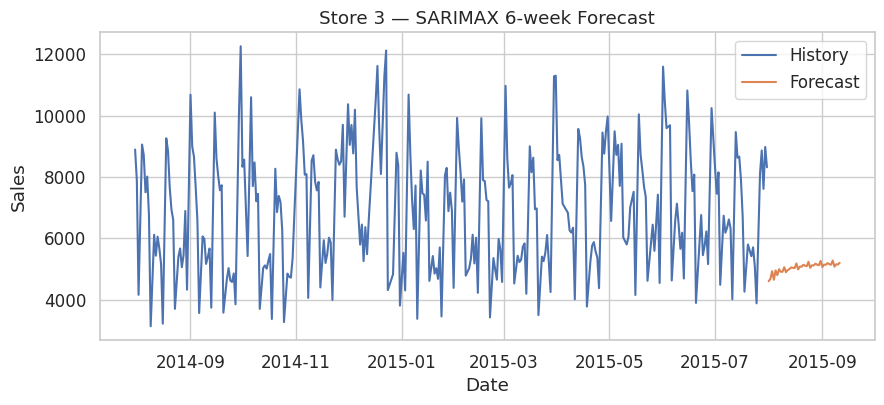

Best model for Store 8 is: SARIMAX

Future 6-week forecast for Store 8


,Store,Date,Sales_Forecast
0,8,2015-08-01,4795.981711
1,8,2015-08-02,5265.993530
2,8,2015-08-03,5050.996736
3,8,2015-08-04,4200.378011
4,8,2015-08-05,5390.231104
5,8,2015-08-06,4889.549531
6,8,2015-08-07,4208.119479
7,8,2015-08-08,5554.603025
8,8,2015-08-09,4564.502393
9,8,2015-08-10,4743.659141


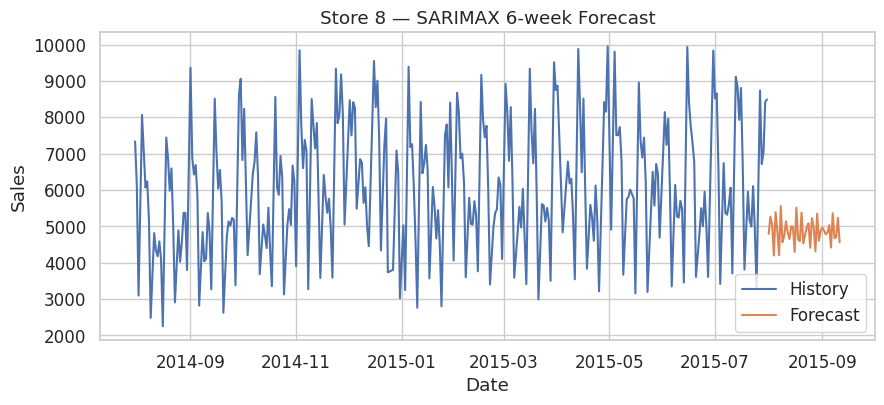

Best model for Store 9 is: SARIMAX

Future 6-week forecast for Store 9


,Store,Date,Sales_Forecast
0,9,2015-08-01,6411.550686
1,9,2015-08-02,6366.056973
2,9,2015-08-03,6347.076422
3,9,2015-08-04,6307.116625
4,9,2015-08-05,6395.748222
5,9,2015-08-06,6335.098351
6,9,2015-08-07,6412.374491
7,9,2015-08-08,6404.504051
8,9,2015-08-09,6303.173355
9,9,2015-08-10,6463.564571


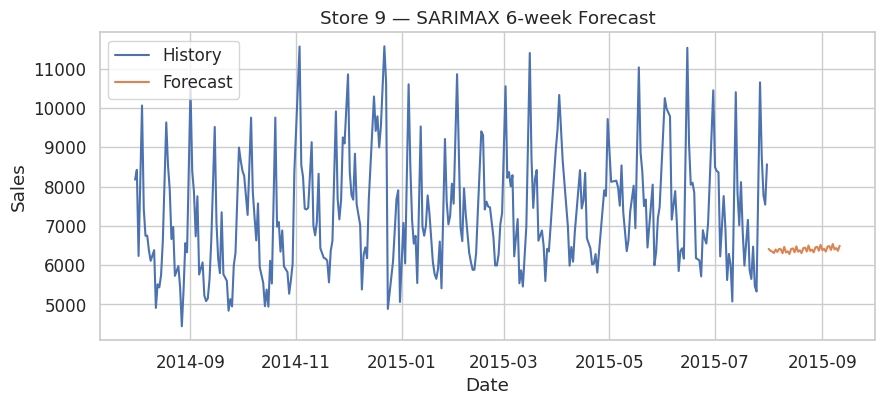

Best model for Store 13 is: SARIMAX

Future 6-week forecast for Store 13


,Store,Date,Sales_Forecast
0,13,2015-08-01,4584.378705
1,13,2015-08-02,4299.588251
2,13,2015-08-03,4359.510666
3,13,2015-08-04,4359.493926
4,13,2015-08-05,4202.344644
5,13,2015-08-06,4221.301685
6,13,2015-08-07,4360.052038
7,13,2015-08-08,4084.742434
8,13,2015-08-09,4212.799639
9,13,2015-08-10,4264.484393


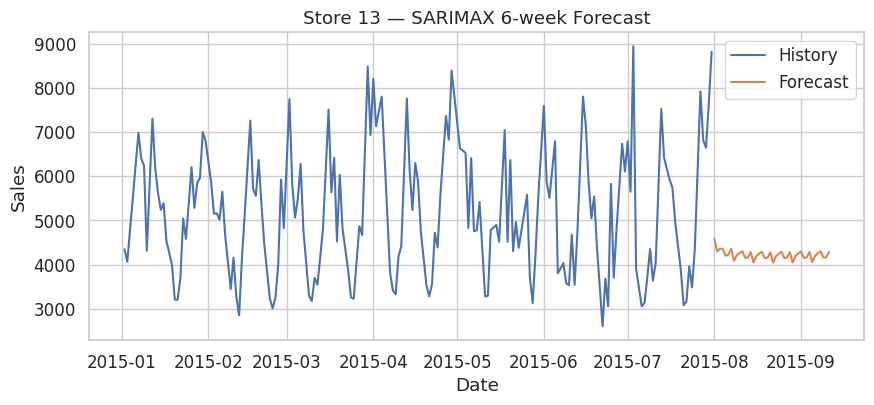

Best model for Store 25 is: SARIMAX

Future 6-week forecast for Store 25


,Store,Date,Sales_Forecast
0,25,2015-08-01,9138.839054
1,25,2015-08-02,9024.309045
2,25,2015-08-03,9430.362604
3,25,2015-08-04,9102.934266
4,25,2015-08-05,9106.305136
5,25,2015-08-06,9565.829580
6,25,2015-08-07,9427.864963
7,25,2015-08-08,9305.591210
8,25,2015-08-09,9308.350363
9,25,2015-08-10,9372.489828


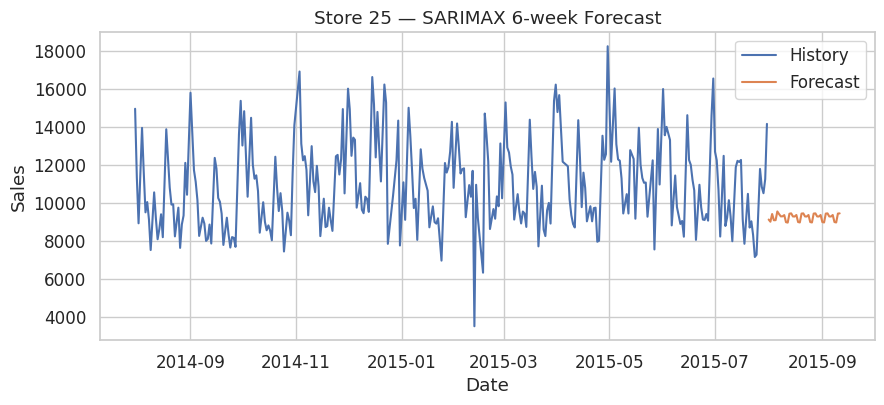

Best model for Store 29 is: VAR_VECM

Johansen Cointegration Test (Trace Statistics):
Trace statistics: [681.06931508 384.76416865 157.2564741 ]
Critical values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Estimated cointegration rank (at 5%): 3
Future forecast with VECM

Future 6-week forecast for Store 29


,Store,Date,Sales_Forecast
0,29,2015-08-01,9215.798795
1,29,2015-08-02,8762.850162
2,29,2015-08-03,8351.532910
3,29,2015-08-04,8013.911902
4,29,2015-08-05,7770.336901
5,29,2015-08-06,7608.160500
6,29,2015-08-07,7508.476857
7,29,2015-08-08,7452.565290
8,29,2015-08-09,7425.225903
9,29,2015-08-10,7415.213930


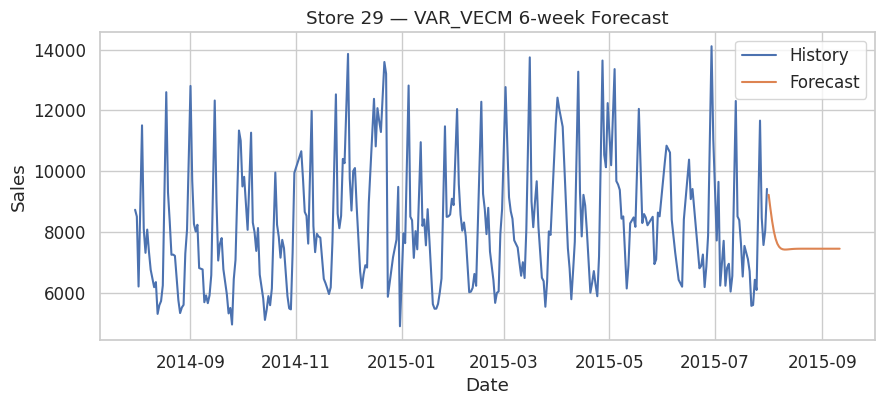

Best model for Store 31 is: SARIMAX

Future 6-week forecast for Store 31


,Store,Date,Sales_Forecast
0,31,2015-08-01,5520.935101
1,31,2015-08-02,5189.977969
2,31,2015-08-03,5150.686638
3,31,2015-08-04,5034.467433
4,31,2015-08-05,5071.132641
5,31,2015-08-06,5029.298220
6,31,2015-08-07,5147.915068
7,31,2015-08-08,5242.417685
8,31,2015-08-09,5108.177733
9,31,2015-08-10,5108.086805


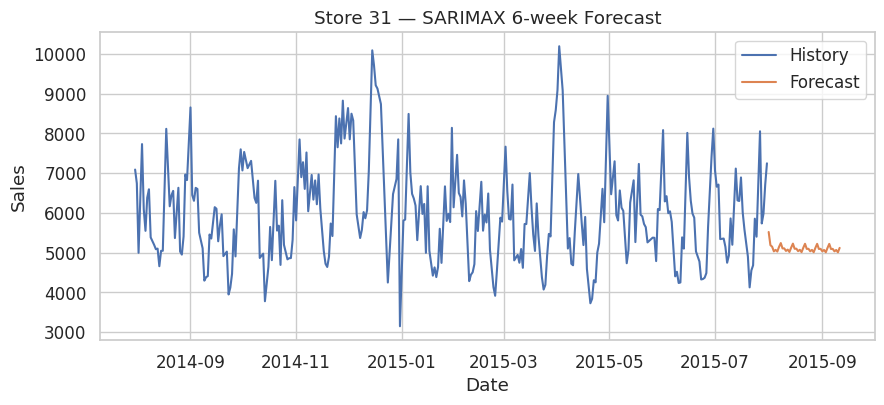

Best model for Store 46 is: ARIMA

Future 6-week forecast for Store 46


,Store,Date,Sales_Forecast
0,46,2015-08-01,6087.504889
1,46,2015-08-02,5198.482331
2,46,2015-08-03,4536.684120
3,46,2015-08-04,4191.584762
4,46,2015-08-05,4204.609814
5,46,2015-08-06,4540.726759
6,46,2015-08-07,5089.558035
7,46,2015-08-08,5691.358650
8,46,2015-08-09,6178.309549
9,46,2015-08-10,6418.554185


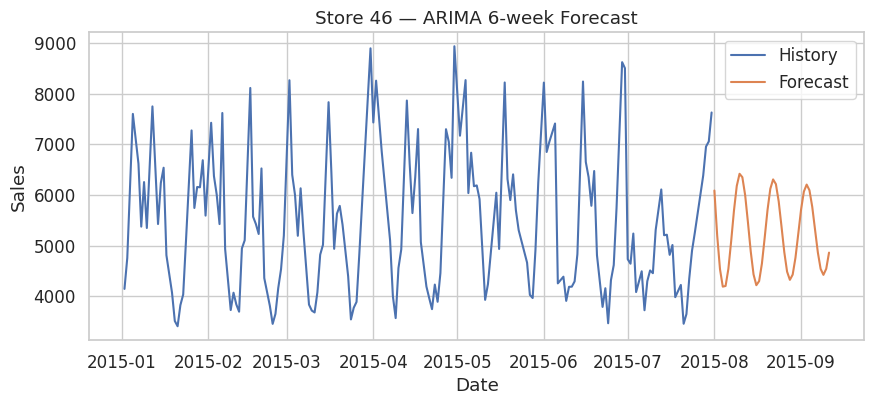

In [30]:
# Example: generate future 6-week forecast for the keys stores using its best model
FUTURE_HORIZON = 42

for store_id in KEY_STORES:
  example_store_for_future = store_id

  if not results_df.empty:
      row = results_df[results_df["Store"] == example_store_for_future]
      if not row.empty:
          best_model = row["Best_Model"].iloc[0]
          print(f"Best model for Store {example_store_for_future} is: {best_model}")

          train_s, test_s = train_test_split_store(df_clean, example_store_for_future)
          #full_series = train_s.append(test_s)
          full_series = pd.concat([train_s, test_s])

          # Build future index (daily)
          last_date = full_series.index.max()
          future_index = pd.date_range(start=last_date + timedelta(days=1),
                                      periods=FUTURE_HORIZON,
                                      freq="D")

          future_forecast = None

          if best_model == "Naive":
              future_forecast = naive_last_value_forecast(full_series, FUTURE_HORIZON)

          elif best_model == "ARIMA":
              arima_full = ARIMA(full_series, order=row["Best_Order"].iloc[0]).fit()
              future_forecast = arima_full.forecast(steps=FUTURE_HORIZON).values

          elif best_model == "SARIMA":
              sarima_full = sm.tsa.statespace.SARIMAX(
                  full_series,
                  order=row["Best_Order"].iloc[0],
                  seasonal_order=(1, 1, 1, 7),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
              ).fit(disp=False)
              future_forecast = sarima_full.forecast(steps=FUTURE_HORIZON).values

          elif best_model == "SARIMAX":
              exog_full = prepare_exog(df_clean, example_store_for_future)
              exog_full = exog_full.reindex(full_series.index).fillna(0)

              sarimax_full = SARIMAX(
                  full_series,
                  exog=exog_full,
                  order=row["Best_Order"].iloc[0],
                  seasonal_order=(1, 1, 1, 7),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
              ).fit(disp=False)

              # Prepare future exog (assume no promo / holidays as baseline)
              exog_future = pd.DataFrame(
                  {
                      "Promo": np.zeros(FUTURE_HORIZON),
                      "SchoolHoliday": np.zeros(FUTURE_HORIZON),
                  },
                  index=future_index,
              )
              future_forecast = sarimax_full.forecast(steps=FUTURE_HORIZON, exog=exog_future).values

          elif best_model == "VAR_VECM":
              var_df_full = prepare_var_data(df_clean, example_store_for_future)
              # We will just reuse the var_vecm function on the full period:
              # fit on full data and forecast FUTURE_HORIZON ahead.
              if len(var_df_full) > FUTURE_HORIZON + 10:
                  train_var_full = var_df_full.copy()
                  scaler = StandardScaler()
                  cols = train_var_full.columns.tolist()
                  train_scaled_full = pd.DataFrame(
                      scaler.fit_transform(train_var_full),
                      index=train_var_full.index,
                      columns=cols,
                  )
                  rank_full = 0
                  if len(cols) >= 2:
                      try:
                          rank_full = johansen_cointegration_test(train_scaled_full, cols)
                      except Exception as e:
                          print("Johansen failed for future, using VAR. Error:", e)
                          rank_full = 0

                  if rank_full > 0:
                      print("Future forecast with VECM")
                      vecm_model_full = VECM(train_scaled_full, k_ar_diff=1, coint_rank=rank_full, deterministic="ci")
                      vecm_res_full = vecm_model_full.fit()
                      #forecast_scaled_full = vecm_res_full.forecast(
                      #    train_scaled_full.values[-vecm_res_full.k_ar_diff:], steps=FUTURE_HORIZON
                      #)
                      forecast_scaled_full = vecm_res_full.predict(
                          steps=FUTURE_HORIZON
                      )
                      forecast_scaled_full = pd.DataFrame(
                          forecast_scaled_full, index=future_index, columns=cols
                      )
                  else:
                      print("Future forecast with VAR")
                      var_model_full = VAR(train_scaled_full)
                      sel_full = var_model_full.select_order(maxlags=7)
                      if hasattr(sel_full.aic, "idxmin"):
                          p_full = sel_full.aic.idxmin()
                      else:
                          p_full = 1
                      var_res_full = var_model_full.fit(p_full)
                      #forecast_scaled_full = var_res_full.forecast(
                      #    train_scaled_full.values[-p_full:], steps=FUTURE_HORIZON
                      #)
                      forecast_scaled_full = var_res_full.predict(
                          steps=FUTURE_HORIZON
                      )
                      forecast_scaled_full = pd.DataFrame(
                          forecast_scaled_full, index=future_index, columns=cols
                      )

                  forecast_orig_full = pd.DataFrame(
                      scaler.inverse_transform(forecast_scaled_full),
                      index=future_index,
                      columns=cols,
                  )
                  future_forecast = forecast_orig_full["Sales"].values

          if future_forecast is not None:
              future_df = pd.DataFrame(
                  {
                      "Store": example_store_for_future,
                      "Date": future_index,
                      "Sales_Forecast": future_forecast,
                  }
              )
              print("\nFuture 6-week forecast for Store", example_store_for_future)
              display(future_df.head(20))

              # Plot only the last 1 year of historical data (for better view of forecast)
              one_year_ago = full_series.index.max() - timedelta(days=365)
              recent_data = full_series[full_series.index >= one_year_ago]

              # Simple plot
              plt.figure(figsize=(10, 4))
              plt.plot(recent_data.index, recent_data.values, label="History")
              plt.plot(future_index, future_forecast, label="Forecast")
              plt.title(f"Store {example_store_for_future} — {best_model} 6-week Forecast")
              plt.xlabel("Date")
              plt.ylabel("Sales")
              plt.legend()
              plt.show()
      else:
          print(f"No results row for Store {example_store_for_future}")
  else:
      print("No results_df available.")



## 13. Interpretation & Summary

- We implemented and compared **five forecasting approaches**:
  1. **Naive last-value** — simple baseline using the last observed value.
  2. **ARIMA** — univariate model capturing autoregressive and moving average structure on differenced data.
  3. **SARIMA** — extends ARIMA with **weekly seasonality** (period 7).
  4. **SARIMAX** — SARIMA with **exogenous inputs** (`Promo`, `SchoolHoliday`) to capture promo / holiday effects.
  5. **VAR / VECM** — multivariate approach using `Sales`, `Customers`, and promotion variables.
     - If **cointegration** is detected (Johansen test), we use **VECM**.
     - Otherwise, we fall back to **VAR**.

- For each store, we:
  - Split the time series into **train** and **test** (last 42 days as test).
  - Fitted each model and computed **MAPE** on the test period.
  - Selected the **best model per store** based on the lowest MAPE.

- Finally, for every store, we:
  - Took the best model and refit it on the full available history.
  - Generated a **6-week ahead forecast** and plotted it.
